## MATH637 Group Project



## 1.Extract US stock market dataset
#### Looking for stock pairs in tech,healthcare and real estate sectors
#### Include adjusted close prices as daily price indicator, combined with daily trading volume which shows the intensity of trading 
#### Choose ten stocks in each sector initially for cointegration test to find proper pairs
#### Source of Data:  Yahoo Finance API (yfinance)


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
# Looking for stock pairs in tech,healthcare and real estate sectors
# For each sector, choose 30 stocks to find cointegrated pairs respectively
sectors = {
    "Technology": ["AAPL", "MSFT", "GOOGL", "NVDA", "META", "TSM", "ORCL", "ADBE", "CSCO", "INTC",
                   "IBM", "SAP", "CRM", "AMD", "TXN", "QCOM", "AVGO", "NOW", "INTU", "SHOP", 
                   "WDAY", "CDNS", "PANW", "SNOW", "SQ", "ZM", "ASML", "MU", "XLNX", "DOCU"],
    "Healthcare": ["JNJ", "PFE", "MRK", "ABBV", "LLY", "TMO", "UNH", "ABT", "BMY", "CVS",
                   "DHR", "AMGN", "GILD", "BIIB", "ZTS", "BDX", "ISRG", "SYK", "BSX", "CI",
                   "HCA", "REGN", "VRTX", "MDT", "MCK", "ILMN", "RHHBY", "ABC", "COO", "TFX"],
    "Real Estate": ["AMT", "PLD", "CCI", "DLR", "EQIX", "O", "SPG", "WELL", "AVB", "EQR",
                    "EXR", "IRM", "ESS", "BXP", "ARE", "PSA", "VTR", "MAA", "HST", "UDR",
                    "SUI", "CPT", "STOR", "KIM", "SLG", "PEAK", "REG", "SRC", "AIV", "BRX"]
}

# Define date range for the last 5 years
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

sector_data = {}

for sector, tickers in sectors.items():
    # Download close price data for each stock in the sector
    data = yf.download(tickers, start=start_date, end=end_date)[['Adj Close','Volume']]
    # Save to dictionary with sector name
    sector_data[sector] = data
    data = data.dropna(axis=1, how='all')
# Display first few rows of each sector's data for verification
for sector, data in sector_data.items():
    print(f"Sector: {sector}")
    print(data.head(), "\n")


[*********************100%%**********************]  30 of 30 completed

14 Failed downloads:
['GOOGL', 'INTC', 'SQ', 'TXN', 'PANW', 'DOCU', 'ASML', 'ZM']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
['XLNX']: Exception('%ticker%: No timezone found, symbol may be delisted')
['CSCO', 'META', 'CRM', 'CDNS', 'AVGO']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%%**********************]  29 of 30 completed

11 Failed downloads:
['ABBV', 'ILMN', 'MRK', 'GILD']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
[*********************100%%**********************]  29 of 30 completed['ABC']: Exception('%ticker%: No timezone found, symbol may be delisted')
['REGN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-12-04 -> 2024-12-04)')
['COO', 'JNJ', 'VRTX', 'MCK', 'AMGN']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='quer

Sector: Technology
Price       Adj Close                                                      \
Ticker           AAPL       ADBE   AMD ASML AVGO CDNS CRM CSCO DOCU GOOGL   
Date                                                                        
2014-12-04  25.718971  73.029999  2.69  NaN  NaN  NaN NaN  NaN  NaN   NaN   
2014-12-05  25.609856  72.400002  2.66  NaN  NaN  NaN NaN  NaN  NaN   NaN   
2014-12-08  25.030844  72.050003  2.58  NaN  NaN  NaN NaN  NaN  NaN   NaN   
2014-12-09  25.413881  71.570000  2.59  NaN  NaN  NaN NaN  NaN  NaN   NaN   
2014-12-10  24.930634  69.849998  2.48  NaN  NaN  NaN NaN  NaN  NaN   NaN   

Price       ...   Volume                                                     \
Ticker      ...     QCOM      SAP SHOP SNOW  SQ       TSM TXN     WDAY XLNX   
Date        ...                                                               
2014-12-04  ...  9374000   898600  NaN  NaN NaN   6130000 NaN  1895900  NaN   
2014-12-05  ...  6588600   877300  NaN  NaN NaN 

#### Filter out non-consitant stock data

In [2]:
# Check consistency of data length and dates across all stocks in each sector
for sector, data in sector_data.items():
    print(f"Checking sector: {sector}")

    # Separate 'Adj Close' and 'Volume' data and create copies to avoid modification warnings
    adj_close_data = data['Adj Close'].copy()
    volume_data = data['Volume'].copy()
    
    # Extract the list of dates for each Ticker's adjusted close prices
    date_lengths = {Ticker: adj_close_data[Ticker].dropna().shape[0] for Ticker in adj_close_data.columns}
    unique_lengths = set(date_lengths.values())
    
    # Check if all stocks have the same number of data points
    if len(unique_lengths) != 1:
        print("Inconsistent data lengths found.")
        print("Data lengths by Ticker:", date_lengths)
    
    # Verify that dates match across all stocks
    all_dates = adj_close_data.index
    stocks_to_drop = []
    for Ticker in adj_close_data.columns:
        stock_dates = adj_close_data[Ticker].dropna().index
        if not stock_dates.equals(all_dates):
            print(f"Dates do not perfectly match for Ticker and is thus dropped: {Ticker}")
            stocks_to_drop.append(Ticker)
    
    # Drop stocks with inconsistent data from both 'Adj Close' and 'Volume'
    if stocks_to_drop:
        adj_close_data.drop(columns=stocks_to_drop, inplace=True)
        volume_data.drop(columns=stocks_to_drop, inplace=True)
        print(f"Stocks dropped: {stocks_to_drop}")

    # Reassemble the cleaned data
    cleaned_data = pd.concat([adj_close_data, volume_data], axis=1, keys=['Adj Close', 'Volume'])
    
    # Save the modified data back to the sector_data dictionary
    sector_data[sector] = cleaned_data
    print("\n")

Checking sector: Technology
Inconsistent data lengths found.
Data lengths by Ticker: {'AAPL': 2516, 'ADBE': 2516, 'AMD': 2516, 'ASML': 0, 'AVGO': 0, 'CDNS': 0, 'CRM': 0, 'CSCO': 0, 'DOCU': 0, 'GOOGL': 0, 'IBM': 2516, 'INTC': 0, 'INTU': 2516, 'META': 0, 'MSFT': 2516, 'MU': 2516, 'NOW': 2516, 'NVDA': 2516, 'ORCL': 2516, 'PANW': 0, 'QCOM': 2516, 'SAP': 2516, 'SHOP': 2402, 'SNOW': 1061, 'SQ': 0, 'TSM': 2516, 'TXN': 0, 'WDAY': 2516, 'XLNX': 0, 'ZM': 0}
Dates do not perfectly match for Ticker and is thus dropped: ASML
Dates do not perfectly match for Ticker and is thus dropped: AVGO
Dates do not perfectly match for Ticker and is thus dropped: CDNS
Dates do not perfectly match for Ticker and is thus dropped: CRM
Dates do not perfectly match for Ticker and is thus dropped: CSCO
Dates do not perfectly match for Ticker and is thus dropped: DOCU
Dates do not perfectly match for Ticker and is thus dropped: GOOGL
Dates do not perfectly match for Ticker and is thus dropped: INTC
Dates do not perfect

In [3]:
# Check if the data length(dates) for each sector after cleaning is consistent, respectively
for sector, data in sector_data.items():
    date_lengths = {Ticker: data['Adj Close'][Ticker].dropna().shape[0] for Ticker in data['Adj Close'].columns}
    unique_lengths = set(date_lengths.values())
    if len(unique_lengths) != 1:
        print(f"Data lengths are inconsistent for sector: {sector}")
        print("Data lengths by Ticker:", date_lengths)
    else:
        print(f"Data lengths are consistent for sector: {sector}")

Data lengths are consistent for sector: Technology
Data lengths are consistent for sector: Healthcare
Data lengths are consistent for sector: Real Estate


## 2.Preprocess the dataset, including drop null values and standardization
#### Since the prices of stocks vary from each other, stock prices are standardized so that the percentages rather than theactual values are considered and modeled.

In [4]:
from sklearn.preprocessing import StandardScaler

# Process each sector's data
for sector, data in sector_data.items():
    
    # Step 1: Drop any rows with null values (ensure data consistency across stocks)
    data = data.dropna()
    
    # Step 2: Save original 'Adj Close' prices
    raw_close_prices = data['Adj Close'].copy()
    
    # Step 3: Standardize 'Adj Close' prices
    scaler = StandardScaler()
    standardized_close = pd.DataFrame(
        scaler.fit_transform(raw_close_prices), 
        index=raw_close_prices.index, 
        columns=raw_close_prices.columns
    )
    
    # Combine original and standardized close prices with volume data
    sector_data[sector] = pd.concat(
        {'Adj Close': raw_close_prices, 'Standardized Close': standardized_close, 'Volume': data['Volume']},
        axis=1
    )

print("Data processing complete.")



Data processing complete.


## 3. Cointegration Test

#### Rationale: Cointegration refers to a statistical relationship where two or more time series move together over the long term, ideal for pairs trading because their prices tend to revert to a stable spread.
#### Two major methods to choose from:
#### (1) Engle-Granger Method:  This test is used to initially screen pairs by checking for cointegration between two time series. It involves a regression between the two series and tests the residuals for stationarity, providing a quick way to filter out potential pairs from a larger dataset
#### (2) Johansen's Method: Johansen accounts for endogeneity, where both stocks might influence each other, making it more reliable. This validation step ensures only pairs with a stable, long-term relationship are selected for trading
#### With such advantages combined, we can firstly implement Engle-Granger Method and then validate the results using Johansen's Method
#### As a result, the spread between selected pairs of stocks will be calculated and displayed 



Potential Pair Found: ABT, ZTS
Engle-Granger Test: p-value: 0.0001, t-statistic: -5.0788
Johansen Test Confirmed: Trace Statistic: 30.5627
Hedge Ratio: 0.5732


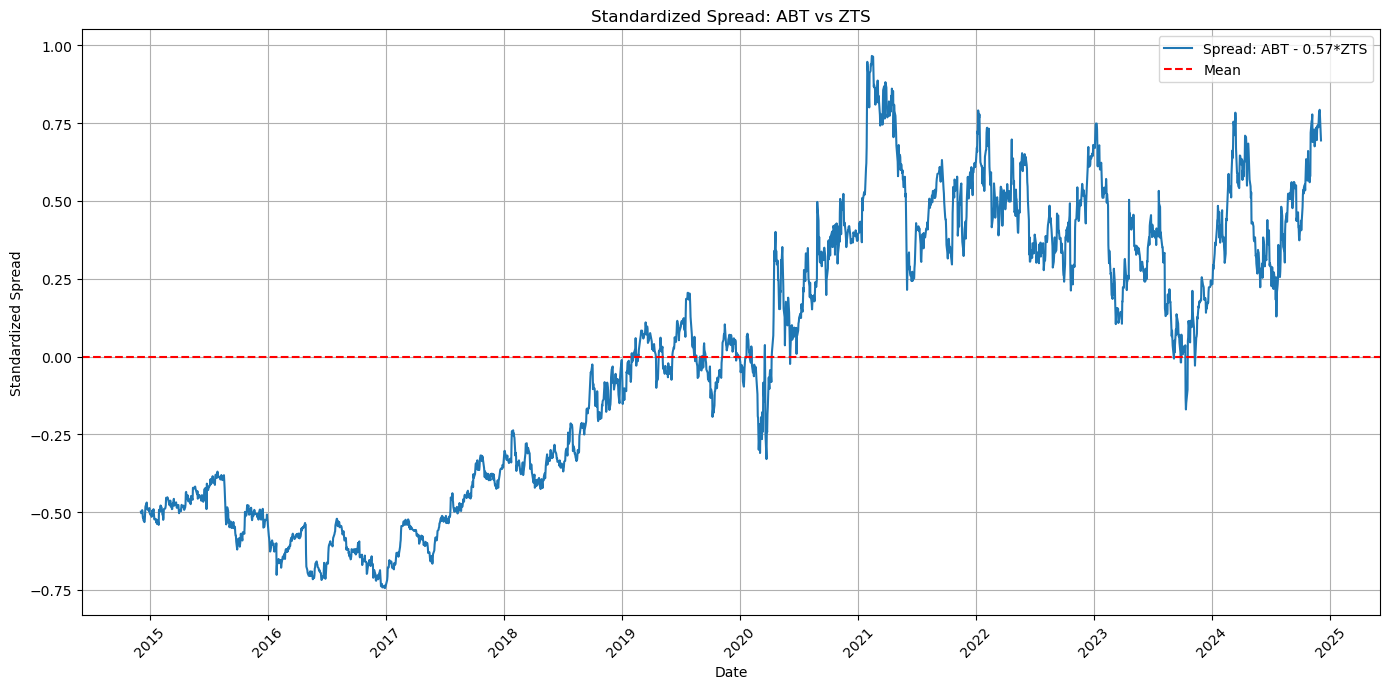


Potential Pair Found: BIIB, BSX
Engle-Granger Test: p-value: 0.0144, t-statistic: -3.7813
Johansen Test Confirmed: Trace Statistic: 21.6085
Hedge Ratio: -2.3065


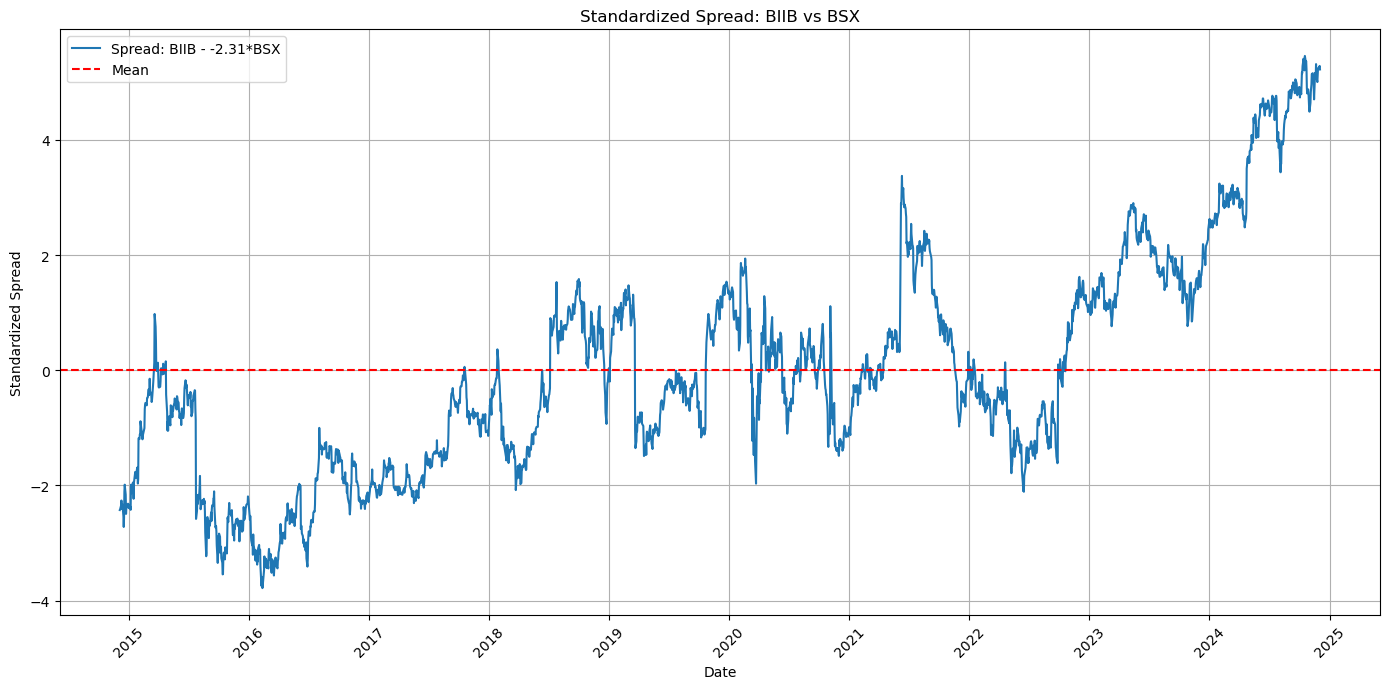


Potential Pair Found: BIIB, HCA
Engle-Granger Test: p-value: 0.0193, t-statistic: -3.6816
Johansen Test Confirmed: Trace Statistic: 32.0834
Hedge Ratio: -0.0444


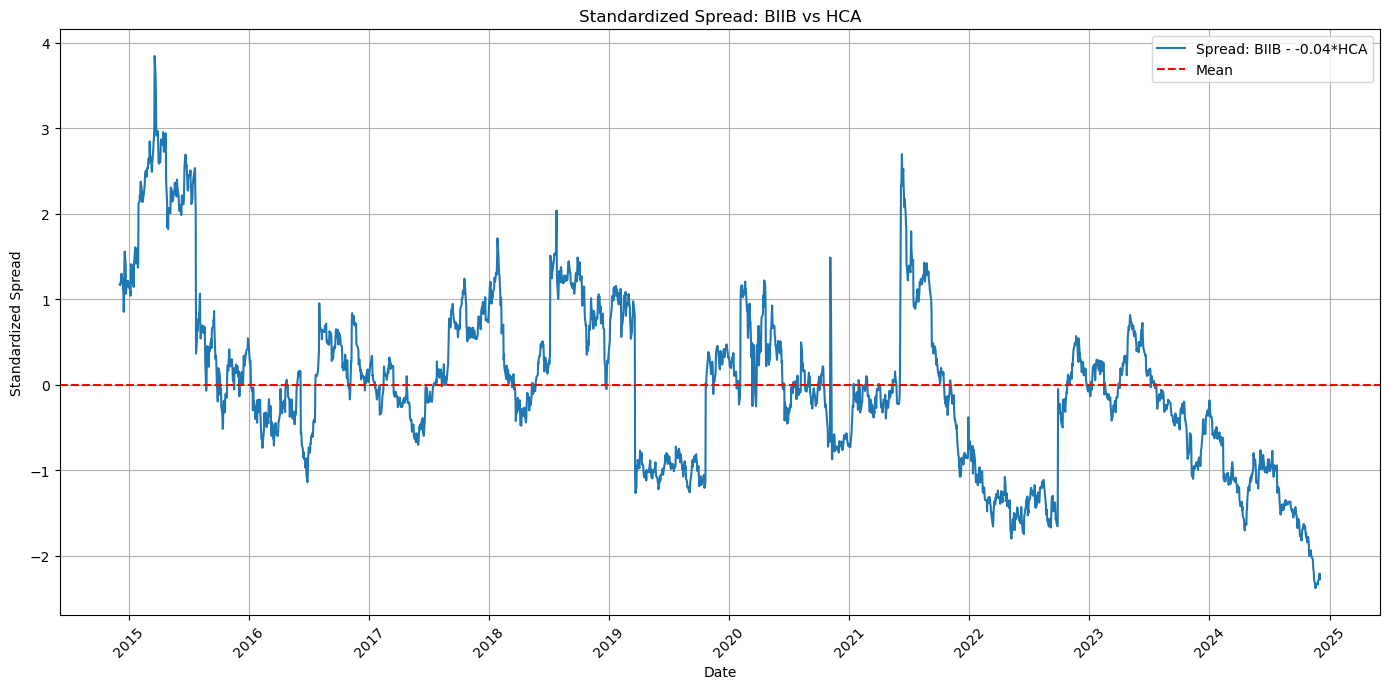


Potential Pair Found: BIIB, ISRG
Engle-Granger Test: p-value: 0.0134, t-statistic: -3.8040
Johansen Test Confirmed: Trace Statistic: 25.4279
Hedge Ratio: -0.3048


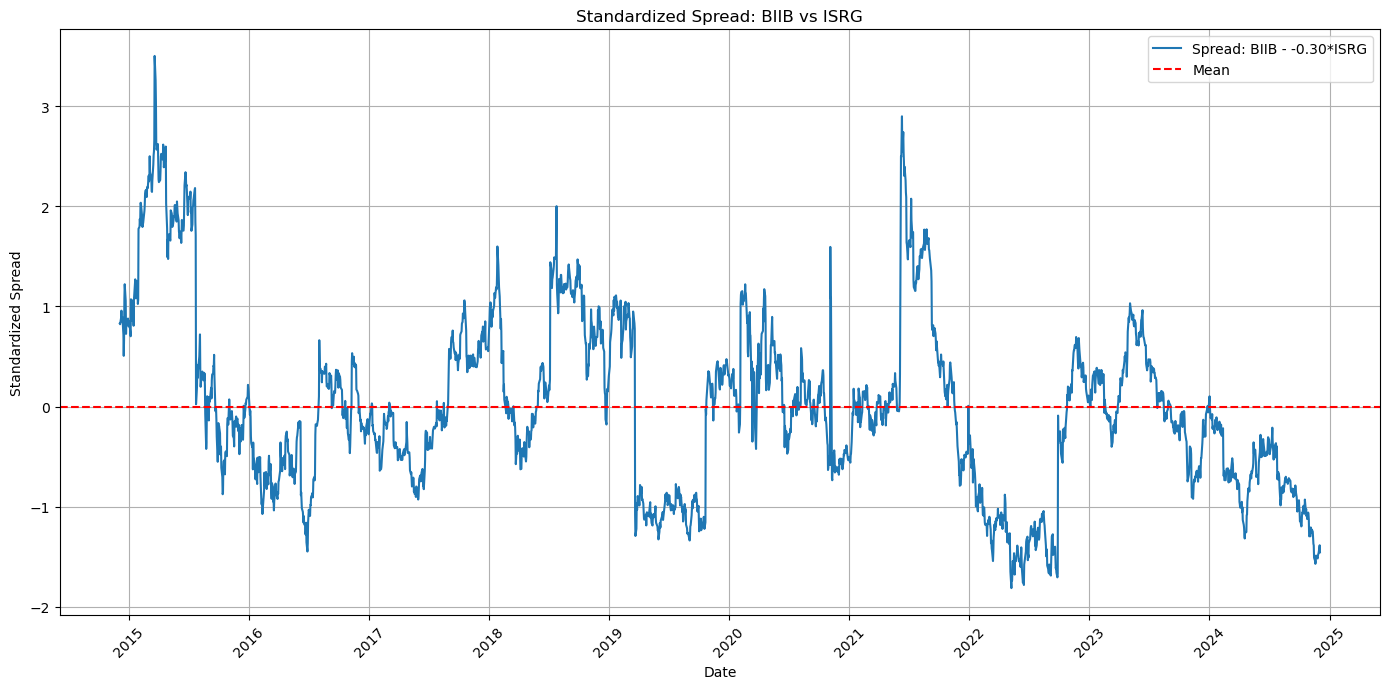


Potential Pair Found: BIIB, LLY
Engle-Granger Test: p-value: 0.0135, t-statistic: -3.8008
Johansen Test Confirmed: Trace Statistic: 22.6671
Hedge Ratio: -0.0892


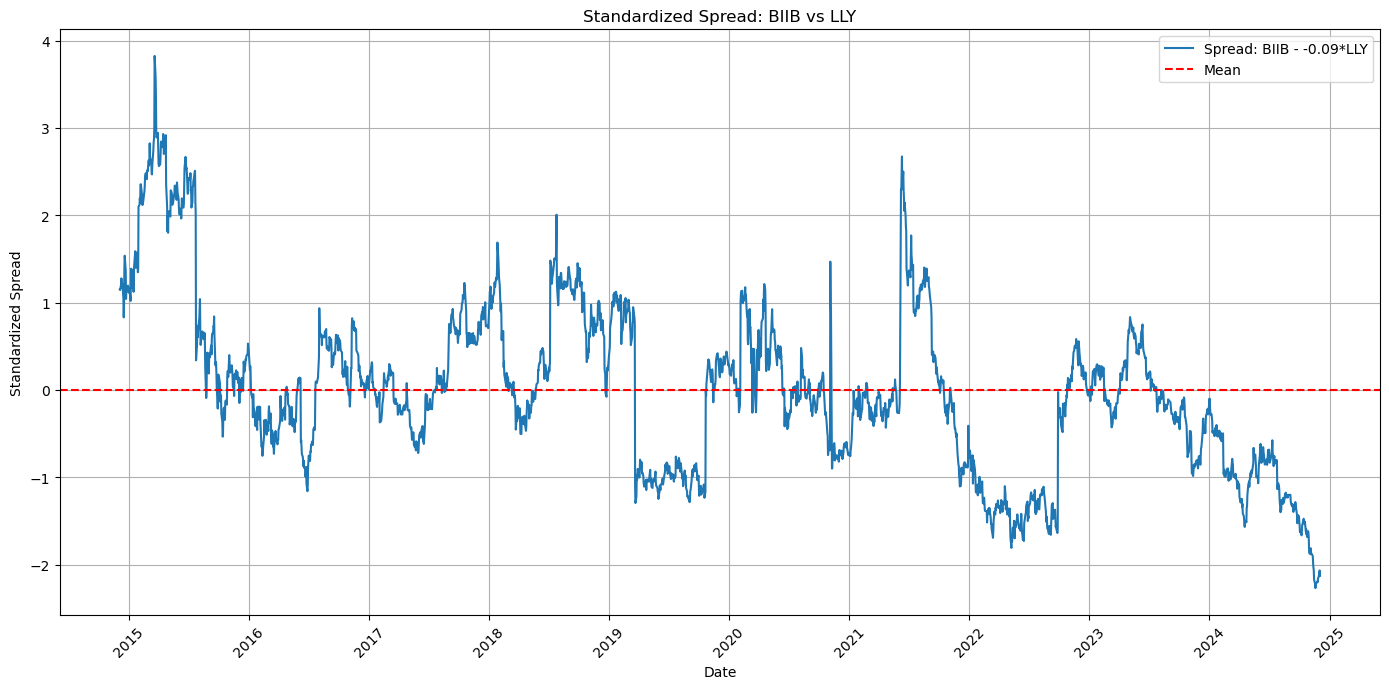


Potential Pair Found: BIIB, UNH
Engle-Granger Test: p-value: 0.0155, t-statistic: -3.7569
Johansen Test Confirmed: Trace Statistic: 30.5659
Hedge Ratio: -0.4403


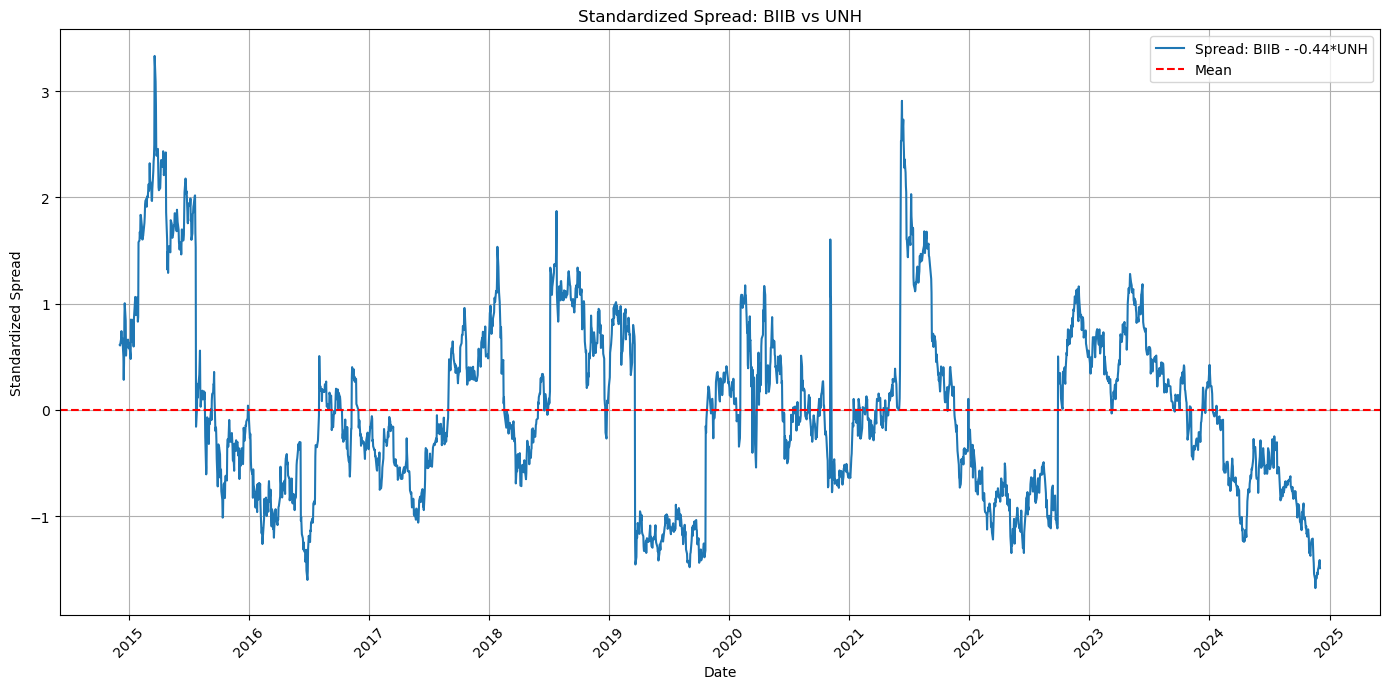


Total validated pairs found: 6
Validated Pairs: [('ABT', 'ZTS'), ('BIIB', 'BSX'), ('BIIB', 'HCA'), ('BIIB', 'ISRG'), ('BIIB', 'LLY'), ('BIIB', 'UNH')]


In [5]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Define a function for cointegration test
def find_cointegrated_pairs(sector_data, sector, p_value_threshold, t_stat_threshold):
    """
    Find cointegrated pairs in a given sector using both Engle-Granger and Johansen tests.
    """
    # Extract price data
    close_prices = sector_data[sector]['Adj Close']
    standardized_close = sector_data[sector]['Standardized Close']
    
    # List to store validated pairs
    validated_pairs_data = []
    
    # Perform tests on each unique pair
    tickers = close_prices.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            stock_a = tickers[i]
            stock_b = tickers[j]
            
            # Get price series for the pair
            prices_a = close_prices[stock_a]
            prices_b = close_prices[stock_b]
            
            try:
                # Step 1: Engle-Granger Test
                t_statistic, p_value, _ = sm.tsa.coint(prices_a, prices_b)
                
                if p_value < p_value_threshold and t_statistic < t_stat_threshold:
                    print(f"\nPotential Pair Found: {stock_a}, {stock_b}")
                    print(f"Engle-Granger Test: p-value: {p_value:.4f}, t-statistic: {t_statistic:.4f}")
                    
                    # Step 2: Johansen Test
                    pair_prices = pd.concat([prices_a, prices_b], axis=1)
                    johansen_test = coint_johansen(pair_prices, det_order=1, k_ar_diff=1)
                    
                    # Check Johansen test at 5% significance
                    if johansen_test.lr1[0] > johansen_test.cvt[0, 1]:
                        print(f"Johansen Test Confirmed: Trace Statistic: {johansen_test.lr1[0]:.4f}")
                        
                        # Calculate hedge ratio from Johansen test
                        hedge_ratio = -johansen_test.evec[:, 0][1] / johansen_test.evec[:, 0][0]
                        print(f"Hedge Ratio: {hedge_ratio:.4f}")
                        
                        # Calculate standardized spread
                        spread_standardized = (standardized_close[stock_a] - 
                                            hedge_ratio * standardized_close[stock_b])
                        
                        # Store pair information
                        pair_data = {
                            'pair': (stock_a, stock_b),
                            'prices': pd.DataFrame({
                                'stock_A': prices_a,
                                'stock_B': prices_b
                            })
                        }
                        validated_pairs_data.append(pair_data)
                        
                        # Plot spread
                        plt.figure(figsize=(14, 7))
                        plt.plot(spread_standardized.index, spread_standardized, 
                               label=f"Spread: {stock_a} - {hedge_ratio:.2f}*{stock_b}")
                        plt.axhline(spread_standardized.mean(), color='red', 
                                  linestyle='--', label='Mean')
                        plt.title(f"Standardized Spread: {stock_a} vs {stock_b}")
                        plt.xlabel("Date")
                        plt.ylabel("Standardized Spread")
                        plt.legend()
                        plt.grid(True)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.show()
                        
            except Exception as e:
                print(f"Error processing pair {stock_a}-{stock_b}: {str(e)}")
                continue
    
    print(f"\nTotal validated pairs found: {len(validated_pairs_data)}")
    print("Validated Pairs:", [pair['pair'] for pair in validated_pairs_data])
    
    return validated_pairs_data

# Usage
sector = "Healthcare"
validated_pairs_data = find_cointegrated_pairs(
    sector_data= sector_data,
    sector='Healthcare',
    p_value_threshold=0.02,
    t_stat_threshold=-3.5
)

In [6]:
print(validated_pairs_data)

[{'pair': ('ABT', 'ZTS'), 'prices':                stock_A     stock_B
Date                              
2014-12-04   37.596371   40.920643
2014-12-05   37.439335   40.902035
2014-12-08   37.778191   41.013638
2014-12-09   37.555035   40.753235
2014-12-10   36.670712   39.776718
...                ...         ...
2024-11-26  117.959999  175.699997
2024-11-27  118.949997  176.740005
2024-11-29  118.769997  175.250000
2024-12-02  116.809998  176.809998
2024-12-03  116.290001  176.940002

[2516 rows x 2 columns]}, {'pair': ('BIIB', 'BSX'), 'prices':                stock_A    stock_B
Date                             
2014-12-04  341.179993  12.780000
2014-12-05  340.869995  12.910000
2014-12-08  344.049988  12.940000
2014-12-09  347.609985  13.040000
2014-12-10  343.589996  12.600000
...                ...        ...
2024-11-26  157.690002  90.209999
2024-11-27  159.830002  90.750000
2024-11-29  160.630005  90.660004
2024-12-02  164.229996  90.430000
2024-12-03  160.850006  90.470001

[25

#### Now the cointegrated pairs are determined, we can start constructing the Deep Q-Networks(DQN) model

## 4.DQN Model Implementation
#### Boundaries are thresholds used to help traders make decisions about when to long or short a trade
#### Use Deep Q Learning (DQN) to select non-explicitly defined boundaries. The goal is to let the trained agent learn to execute strategies with optimized boundaries. 
#### Incorporate moving formation and trading windows into the training model.

In [7]:
# Step 1: Define the DQN Network for Trading Actions
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),  # Increased size for more expressive power
            nn.ReLU(),
            nn.Linear(128, 128),  # Additional hidden layer
            nn.ReLU(),
            nn.Linear(128, 256),   # Additional hidden layer for deeper learning
            nn.ReLU(),
            nn.Linear(256, action_dim)  # Output layer for action values
        )

    def forward(self, state):
        return self.fc(state)
    


#### Define the einforcement learning environment using the gym library.

In [8]:
class PairsTradingEnv(gym.Env):
    def __init__(self, prices, formation_window_size, trading_window_size):
        super(PairsTradingEnv, self).__init__()
        
        self.prices_A = prices['stock_A'].values
        self.prices_B = prices['stock_B'].values
        self.dates = prices['dates']

        boundary_settings = [
            {'trade': 0.5, 'stop_loss': 3},
            {'trade': 1.5, 'stop_loss': 3.5},
            {'trade': 2, 'stop_loss': 4},
            {'trade': 2.5, 'stop_loss': 4.5},
            {'trade': 3, 'stop_loss': 5},
            {'trade': 3.5, 'stop_loss': 6},
            {'trade':float('inf'), 'stop_loss':float('inf')}
        ]
        self.boundary_settings = boundary_settings
        self.formation_window_size = formation_window_size
        self.trading_window_size = trading_window_size
        
        # Action space: select a boundary setting
        self.action_space = spaces.Discrete(len(self.boundary_settings))
        
        # Observation space: [hedge_ratio, spread_mean, spread_std]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32)
        
        # Initialize variables
        self.current_step = 0
        self.total_steps = len(self.prices_A) - (formation_window_size + trading_window_size)
        if self.total_steps <= 0:
            raise ValueError("Not enough data for the specified formation and trading windows.")
        
        self.position = 0
        self.entry_price_A = None
        self.entry_price_B = None
        self.total_reward = 0  # Track total reward for the episode

        self.normal_close_count = 0
        self.stop_loss_count = 0
        self.exit_count = 0
        self.trades = []  # Initialize list to store trade details
        
    def reset(self):
        # Reset positions and rewards
        self.position = 0
        self.entry_price_A = None
        self.entry_price_B = None
        self.total_reward = 0

        self.normal_close_count = 0
        self.stop_loss_count = 0
        self.exit_count = 0

        # Reset current_step to 0 at the beginning of each episode
        self.current_step = 0
        
        # Extract formation and trading windows for the first step
        return self._get_state()
    
    def _get_state(self):
        # Ensure we have enough data left
        if self.current_step > self.total_steps:
            return None  # No more data
        
        # Set the start and end indices for the current window
        self.start_index = self.current_step
        self.end_index = self.start_index + self.formation_window_size + self.trading_window_size
        
        # Extract formation and trading windows
        self.formation_prices_A = self.prices_A[self.start_index:self.start_index + self.formation_window_size]
        self.formation_prices_B = self.prices_B[self.start_index:self.start_index + self.formation_window_size]
        self.trading_prices_A = self.prices_A[self.start_index + self.formation_window_size:self.end_index]
        self.trading_prices_B = self.prices_B[self.start_index + self.formation_window_size:self.end_index]
        
        # Calculate hedge ratio using OLS
        self.hedge_ratio = self.calculate_hedge_ratio(self.formation_prices_A, self.formation_prices_B)
        
        # Calculate spread
        self.formation_spread = self.formation_prices_A - self.hedge_ratio * self.formation_prices_B
        self.spread_mean = np.mean(self.formation_spread)
        self.spread_std = np.std(self.formation_spread)
        
        # State is based on formation window statistics
        state = np.array([self.hedge_ratio, self.spread_mean, self.spread_std], dtype=np.float32)
        return state
    
    def calculate_hedge_ratio(self, prices_A, prices_B):
        """Calculate hedge ratio using OLS regression"""
        X = np.array(prices_B).reshape(-1, 1)  # Convert Series to numpy array
        y = prices_A
        model = LinearRegression()
        model.fit(X, y)
        hedge_ratio = model.coef_[0]
        return hedge_ratio
    
    def step(self, action):
        # Set boundaries based on action
        boundaries = self.boundary_settings[action]
        trade_boundary = boundaries['trade']
        stop_loss_boundary = boundaries['stop_loss']
        
        # Simulate trading over the trading window
        reward = self.simulate_trading(trade_boundary, stop_loss_boundary)
        self.total_reward += reward
        
        # Move to the next window
        self.current_step += self.trading_window_size
        
        # Check if we have reached the end of the data
        done = self.current_step > self.total_steps
        if not done:
            next_state = self._get_state()
        else:
            next_state = None

        return next_state, reward, done,{}
    
    def simulate_trading(self, trade_boundary, stop_loss_boundary):
        total_reward = 0
        self.position = 0  # Ensure position is reset
        self.entry_price_A = None
        self.entry_price_B = None
        volume_A = 1  # Assume 1 unit for simplicity
        volume_B = abs(self.hedge_ratio)  # Hedge ratio determines the volume of B
        entry_time = None  # Initialize entry_time

        # Get the actual dates for this trading window
        trading_dates = self.dates[self.start_index + self.formation_window_size:self.end_index]
        for t in range(len(self.trading_prices_A)):
            price_A = self.trading_prices_A[t]
            price_B = self.trading_prices_B[t]
            current_date = trading_dates[t]
            spread_t = price_A - self.hedge_ratio * price_B
            zscore_t = (spread_t - self.spread_mean) / self.spread_std

            if self.position == 0:
                if zscore_t >= trade_boundary and zscore_t < stop_loss_boundary:
                    # Open short position
                    self.position = -1
                    self.entry_price_A = price_A
                    self.entry_price_B = price_B
                    entry_time = current_date  # Store actual date
                elif zscore_t <= -trade_boundary and zscore_t > -stop_loss_boundary:
                    # Open long position
                    self.position = 1
                    self.entry_price_A = price_A
                    self.entry_price_B = price_B
                    entry_time = current_date
            else:
                # Check for position closing conditions
                action = None
                if self.position == 1:
                    if zscore_t >= 0:
                        action = 'normal_close'
                        self.normal_close_count += 1
                    elif zscore_t <= -stop_loss_boundary:
                        action = 'stop_loss'
                        self.stop_loss_count += 1
                        
                elif self.position == -1:  # Short position
                    if zscore_t <= 0:
                        action = 'normal_close'
                        self.normal_close_count += 1
                    elif zscore_t >= stop_loss_boundary:
                        action = 'stop_loss'
                        self.stop_loss_count += 1


                if action:
                    reward = self.calculate_reward(
                        self.entry_price_A, self.entry_price_B,
                        price_A, price_B,
                        volume_A, volume_B,
                        self.position, action
                    )
                    total_reward += reward
                    # Record trade details
                    trade_details = {
                        'entry_date': entry_time,
                        'exit_date': current_date,
                        'position': self.position,
                        'entry_price_A': self.entry_price_A,
                        'entry_price_B': self.entry_price_B,
                        'exit_price_A': price_A,
                        'exit_price_B': price_B,
                        'volume_A': volume_A,
                        'volume_B': volume_B,
                        'action': action,
                        'profit': reward
                    }
                    self.trades.append(trade_details)

                    # Reset position and entry information
                    self.position = 0
                    self.entry_price_A = None
                    self.entry_price_B = None
                    entry_time = None  # Reset entry_time

        # At the end of the trading window, close any open positions
        if self.position != 0:
            action = 'exit'
            self.exit_count += 1
            price_A = self.trading_prices_A[-1]
            price_B = self.trading_prices_B[-1]
            reward = self.calculate_reward(
                self.entry_price_A, self.entry_price_B,
                price_A, price_B,
                volume_A, volume_B,
                self.position, action
            )
            total_reward += reward


            # Record trade details
            current_date = trading_dates[-1]  # Use last date in window
            trade_details = {
                'entry_date': entry_time,
                'exit_date': current_date,
                'position': self.position,
                'entry_price_A': self.entry_price_A,
                'entry_price_B': self.entry_price_B,
                'exit_price_A': self.trading_prices_A[-1],
                'exit_price_B': self.trading_prices_B[-1],
                'volume_A': volume_A,
                'volume_B': volume_B,
                'action': 'exit',
                'profit': reward
            }
            self.trades.append(trade_details)

            # Reset position and entry information
            self.position = 0
            self.entry_price_A = None
            self.entry_price_B = None
            entry_time = None  # Reset entry_time
            
        return total_reward
    
    def calculate_reward(self, entry_price_A, entry_price_B, current_price_A, current_price_B, volume_A, volume_B, position, action):
        # Ensure entry prices are not None when calculating reward
        assert entry_price_A is not None and entry_price_B is not None, "Entry prices should not be None when calculating reward."
        reward= 0
        # Reward calculation based on position and exit condition
        if position == 1:  # Long position
            W_t = (
                volume_A * ((current_price_A - entry_price_A) / entry_price_A) +
                volume_B * ((entry_price_B - current_price_B) / entry_price_B)
            )
        elif position == -1:  # Short position
            W_t = (
                volume_A * ((entry_price_A - current_price_A) / entry_price_A) +
                volume_B * ((current_price_B - entry_price_B) / entry_price_B)
            )
        else:
            W_t = 0

        if action == 'normal_close':
            reward= 1000 * abs(W_t)  # Adjusted multiplier for normal close
        elif action == 'stop_loss':
            reward = -1000* abs(W_t)  # Adjusted penalty for stop-loss
        elif action == 'exit':
            reward = -500 * abs(W_t)  # Adjusted penalty for forced exit
        else:
            reward = 0
        return reward

#### Configuration of key training parameters

In [ ]:
def get_hyperparameters():
    
    hyperparameters = {
        'gamma': 0.99,
        'epsilon_start': 1,
        'epsilon_end': 0.01,
        'epsilon_decay': 0.95,
        'learning_rate': 0.01,
        'batch_size': 128,
        'target_update_freq': 100,
        'num_episodes': 200,  # Set the desired number of training episodes
    }
    return hyperparameters

#### Start to train the Deep Q-Network (DQN) agent
#### Record the agent and save the rewards and Q value

In [10]:
def train_agent(training_prices,formation_window_size, trading_window_size):
    # Get hyperparameters
    hyperparams = get_hyperparameters()
    gamma = hyperparams['gamma']
    epsilon = hyperparams['epsilon_start']
    epsilon_min = hyperparams['epsilon_end']
    epsilon_decay = hyperparams['epsilon_decay']
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    target_update_freq = hyperparams['target_update_freq']
    num_episodes = hyperparams['num_episodes']
    
    # Initialize agent and optimizer
    state_dim = 3  # [hedge_ratio, spread_mean, spread_std]
    action_dim = 7  # Number of boundary settings
    
    agent = DQN(state_dim, action_dim)
    target_agent = DQN(state_dim, action_dim)
    target_agent.load_state_dict(agent.state_dict())
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
    
    replay_buffer = deque(maxlen=10000)
    total_rewards = []
    avg_q_values_per_episode = []  # To store average Q-values per episode
    step_count = 0
    # Initialize lists to store counts
    normal_close_counts = []
    stop_loss_counts = []
    exit_counts = []
    for episode in range(num_episodes):
        # Create environment for each episode
        env = PairsTradingEnv(
            prices = training_prices,
            formation_window_size=formation_window_size,
            trading_window_size=trading_window_size
        )
        
        state = env.reset()
        done = False
        episode_q_values = []  # To store Q-values in this episode
        
        while not done:
            # Compute Q-values for the current state
            state = np.array(state, dtype=np.float32)
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = agent(state_tensor)
                # Compute mean Q-value and collect it
                mean_q_value = q_values.mean().item()
                episode_q_values.append(mean_q_value)
            
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()
            
            # Execute trading strategy and obtain reward
            next_state, reward, done, info = env.step(action)
            
            # Store transition in replay buffer
            replay_buffer.append((state, action, reward, next_state, done))
            
            # Training
            if len(replay_buffer) >= batch_size:
                minibatch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)
                
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)
                
                # Compute targets
                q_values_pred = agent(states).gather(1, actions)
                with torch.no_grad():
                    next_q_values = torch.zeros(batch_size)
                    for idx, next_state in enumerate(next_states):
                        if next_state is not None:
                            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
                            next_q_values[idx] = target_agent(next_state_tensor).max(1)[0]
                target_q_values = rewards + (1 - dones) * gamma * next_q_values
                
                # Update agent
                loss = nn.functional.mse_loss(q_values_pred.squeeze(), target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update target network
                if step_count % target_update_freq == 0:
                    target_agent.load_state_dict(agent.state_dict())
                step_count += 1
            
            # Move to next state
            state = next_state if next_state is not None else state
        
        # At the end of the episode, compute average Q-value
        avg_q_value = np.mean(episode_q_values)
        avg_q_values_per_episode.append(avg_q_value)
        
        # Collect total rewards
        total_rewards.append(env.total_reward)
        normal_close_counts.append(env.normal_close_count)
        stop_loss_counts.append(env.stop_loss_count)
        exit_counts.append(env.exit_count)
        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Optional: Print progress
        if episode % 10 == 0:
            print(f'Episode {episode}, Total Reward: {env.total_reward:.2f}, Epsilon: {epsilon:.4f}, Avg Q-value: {avg_q_value:.4f}')
    
    # Plot total rewards
    plt.figure()
    plt.plot(total_rewards, label='Total Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Total Reward per Episode\nFormation Window: {formation_window_size}, Trading Window: {trading_window_size}')

    
    # Fit a linear regression model to the total rewards
    X = np.arange(len(total_rewards)).reshape(-1, 1)
    y = np.array(total_rewards).reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Plot the linear regression line
    plt.plot(X, y_pred, color='red', linestyle='--', label='Linear Regression')
    plt.legend()
    plt.show()

    counts = {
        'normal_close': [nc / (nc + sl + ex) for nc, sl, ex in zip(normal_close_counts, stop_loss_counts, exit_counts)],
        'stop_loss': [sl / (nc + sl + ex) for nc, sl, ex in zip(normal_close_counts, stop_loss_counts, exit_counts)],
        'exit': [ex / (nc + sl + ex) for nc, sl, ex in zip(normal_close_counts, stop_loss_counts, exit_counts)]
    }
    # Plot counts per episode
    plt.figure(figsize=(10, 6))
    plt.plot(counts['normal_close'], label='Normal Close')
    plt.plot(counts['stop_loss'], label='Stop Loss')
    plt.plot(counts['exit'], label='Exit')
    plt.xlabel('Episode')
    plt.ylabel('Ratio of Occurrence')
    plt.title(f'Ratio of Portfolio Closures per Episode\nFormation Window: {formation_window_size}, Trading Window: {trading_window_size}')
    plt.legend()
    plt.show()

    # Plot average Q-values per episode
    plt.figure()
    plt.plot(avg_q_values_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Average Q-value')
    plt.title(f'Average Q-value per Episode\nFormation Window: {formation_window_size}, Trading Window: {trading_window_size}')
    plt.show()

    # Save the trained agent
    #torch.save(agent.state_dict(), 'trained_agent.pth')
    return agent, total_rewards, avg_q_values_per_episode


In [11]:
def stock_Data(pair_data): # Train the agent using the training data
    """
    Process pair data and split into training and test sets while preserving dates
    
    Args:
        pair_data: Dictionary containing pair information and price data
        
    Returns:
        List containing training and test price dictionaries with dates
    """
    print("Selected Pair:", pair_data['pair'])
    
    # Get the price DataFrame which now has dates as index
    prices_df = pair_data['prices']
    
    # Split the data into training (50%) and test (50%) sets
    split_index = len(prices_df) // 2
    
    # Create training and test sets with dates preserved
    train_prices = {
        'stock_A': prices_df['stock_A'].iloc[:split_index],
        'stock_B': prices_df['stock_B'].iloc[:split_index],
        'dates': prices_df.index[:split_index]
    }
    
    test_prices = {
        'stock_A': prices_df['stock_A'].iloc[split_index:],
        'stock_B': prices_df['stock_B'].iloc[split_index:],
        'dates': prices_df.index[split_index:]
    }
    
    return [train_prices, test_prices]

#### Models are trained in the form of an agent, each configured with different formation window sizes and trading window sizes.
#### Since the training is computationally expensive, only a simple collection of window sizes is used to find the best window configurations.

Selected Pair: ('BIIB', 'BSX')
Episode 0, Total Reward: -3019.43, Epsilon: 0.9500, Avg Q-value: -1.6860


C:\Users\94857\AppData\Local\Temp\ipykernel_20956\1088869001.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 10, Total Reward: 2852.17, Epsilon: 0.5688, Avg Q-value: 2833.7454
Episode 20, Total Reward: 10233.94, Epsilon: 0.3406, Avg Q-value: 5421.8226
Episode 30, Total Reward: 1712.74, Epsilon: 0.2039, Avg Q-value: 6285.7745
Episode 40, Total Reward: 7748.51, Epsilon: 0.1221, Avg Q-value: 7412.7138
Episode 50, Total Reward: 8525.35, Epsilon: 0.0731, Avg Q-value: 9237.0548
Episode 60, Total Reward: 10594.99, Epsilon: 0.0438, Avg Q-value: 11535.8747
Episode 70, Total Reward: 1578.55, Epsilon: 0.0262, Avg Q-value: 12283.4437
Episode 80, Total Reward: 12115.75, Epsilon: 0.0157, Avg Q-value: 13425.2898
Episode 90, Total Reward: 10598.77, Epsilon: 0.0100, Avg Q-value: 13873.8167
Episode 100, Total Reward: 6152.32, Epsilon: 0.0100, Avg Q-value: 14216.9429
Episode 110, Total Reward: 6094.37, Epsilon: 0.0100, Avg Q-value: 13841.8831
Episode 120, Total Reward: 12685.16, Epsilon: 0.0100, Avg Q-value: 13571.8403
Episode 130, Total Reward: 5168.14, Epsilon: 0.0100, Avg Q-value: 14276.8394
Episode 

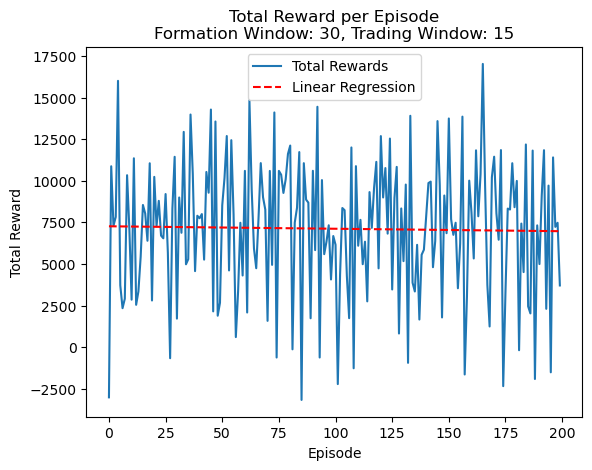

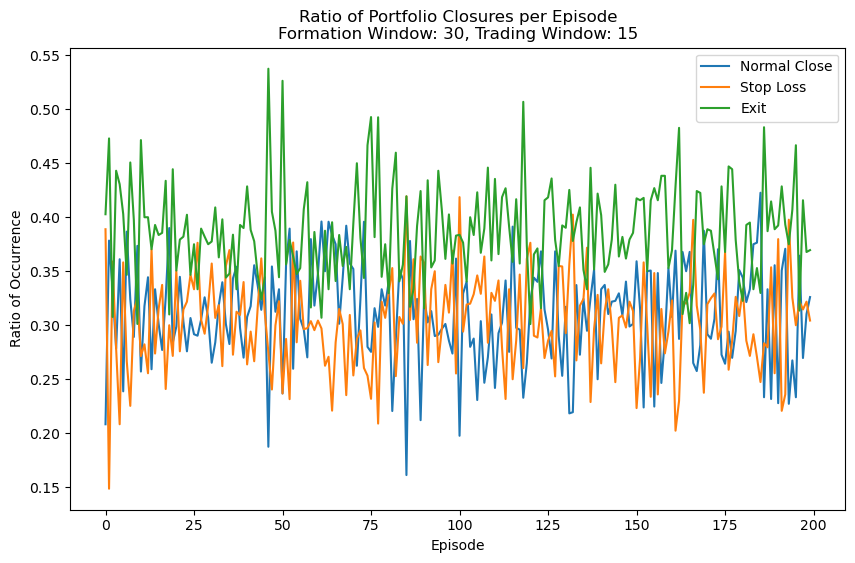

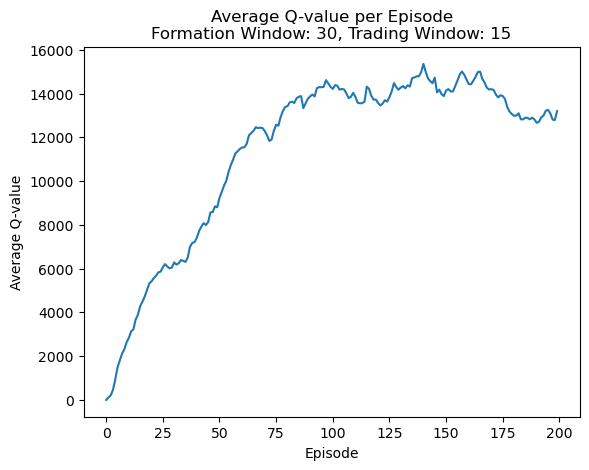

Selected Pair: ('BIIB', 'BSX')
Episode 0, Total Reward: 1674.21, Epsilon: 0.9500, Avg Q-value: 0.7013
Episode 10, Total Reward: 8830.44, Epsilon: 0.5688, Avg Q-value: 3752.8162
Episode 20, Total Reward: 11717.71, Epsilon: 0.3406, Avg Q-value: 4986.6897
Episode 30, Total Reward: -6368.02, Epsilon: 0.2039, Avg Q-value: 5339.0457
Episode 40, Total Reward: 10535.26, Epsilon: 0.1221, Avg Q-value: 6803.1034
Episode 50, Total Reward: 15394.02, Epsilon: 0.0731, Avg Q-value: 8271.0002
Episode 60, Total Reward: 9035.86, Epsilon: 0.0438, Avg Q-value: 10022.7200
Episode 70, Total Reward: 1750.78, Epsilon: 0.0262, Avg Q-value: 9185.1818
Episode 80, Total Reward: 4236.13, Epsilon: 0.0157, Avg Q-value: 9182.0565
Episode 90, Total Reward: 604.11, Epsilon: 0.0100, Avg Q-value: 10245.0027
Episode 100, Total Reward: 4892.71, Epsilon: 0.0100, Avg Q-value: 10203.8907
Episode 110, Total Reward: 4779.83, Epsilon: 0.0100, Avg Q-value: 10417.7721
Episode 120, Total Reward: 3972.28, Epsilon: 0.0100, Avg Q-value

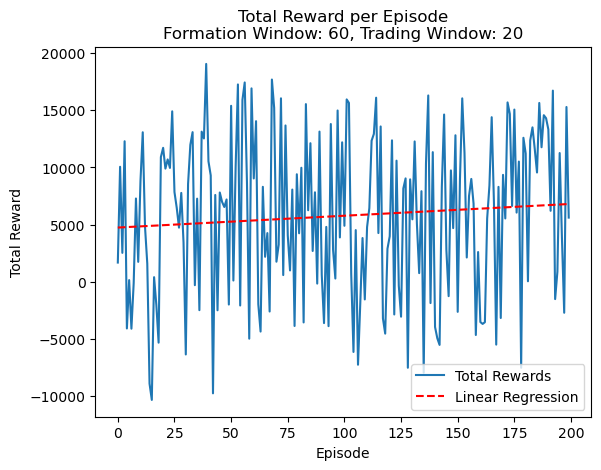

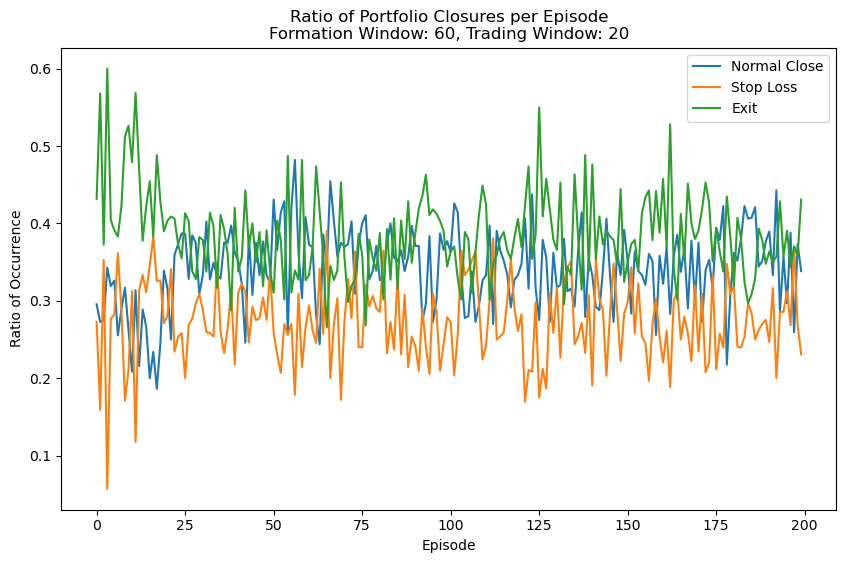

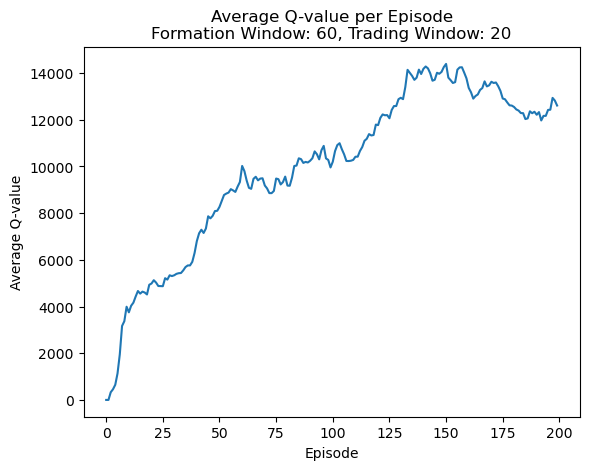

Selected Pair: ('BIIB', 'BSX')
Episode 0, Total Reward: -9135.51, Epsilon: 0.9500, Avg Q-value: -2.2859
Episode 10, Total Reward: -14896.97, Epsilon: 0.5688, Avg Q-value: 574.4031
Episode 20, Total Reward: -13148.43, Epsilon: 0.3406, Avg Q-value: 1309.0474
Episode 30, Total Reward: -11938.53, Epsilon: 0.2039, Avg Q-value: 1640.9927
Episode 40, Total Reward: 6395.14, Epsilon: 0.1221, Avg Q-value: 1479.5297
Episode 50, Total Reward: -9423.55, Epsilon: 0.0731, Avg Q-value: 1258.3312
Episode 60, Total Reward: 11781.09, Epsilon: 0.0438, Avg Q-value: 1319.2361
Episode 70, Total Reward: -11262.17, Epsilon: 0.0262, Avg Q-value: 1126.6943
Episode 80, Total Reward: 14456.31, Epsilon: 0.0157, Avg Q-value: 1056.1781
Episode 90, Total Reward: -5736.61, Epsilon: 0.0100, Avg Q-value: 812.3066
Episode 100, Total Reward: -3081.47, Epsilon: 0.0100, Avg Q-value: 647.5085
Episode 110, Total Reward: -2160.41, Epsilon: 0.0100, Avg Q-value: 513.1864
Episode 120, Total Reward: 14342.28, Epsilon: 0.0100, Avg Q

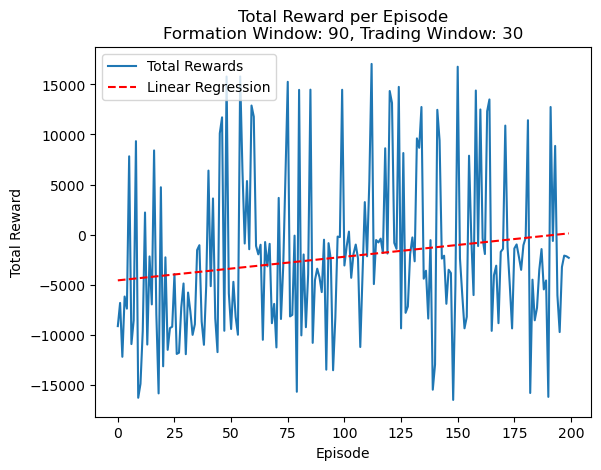

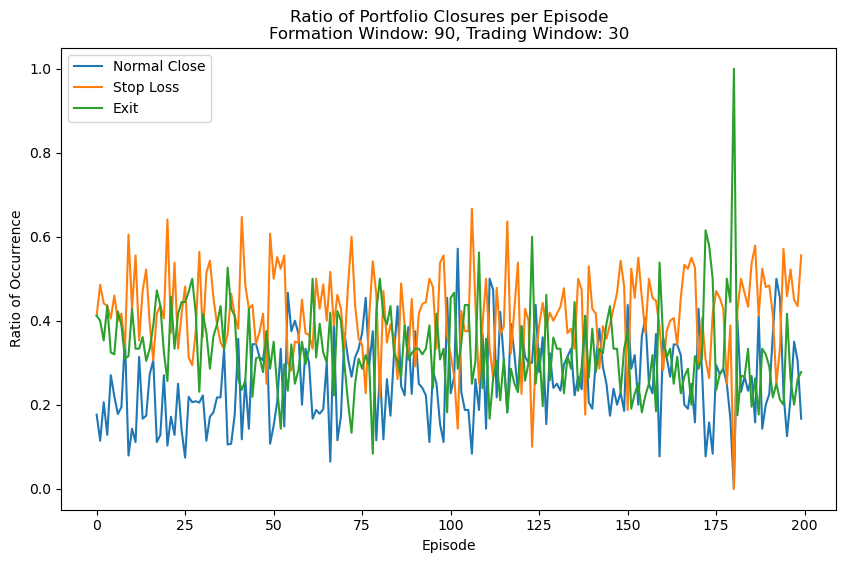

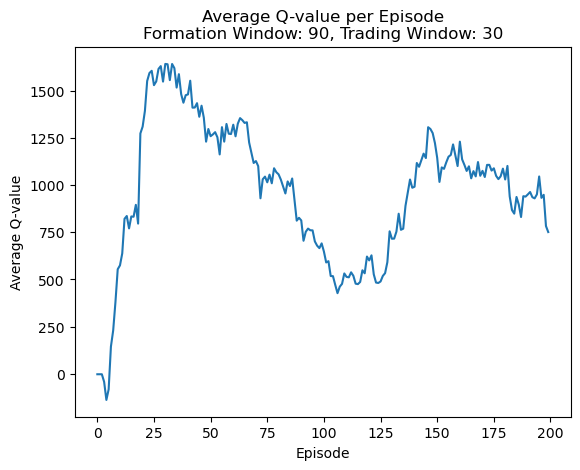

Selected Pair: ('BIIB', 'BSX')
Episode 0, Total Reward: -557.26, Epsilon: 0.9500, Avg Q-value: 1.2149
Episode 10, Total Reward: -2249.66, Epsilon: 0.5688, Avg Q-value: -206.2460
Episode 20, Total Reward: 1403.01, Epsilon: 0.3406, Avg Q-value: -114.1375
Episode 30, Total Reward: 632.58, Epsilon: 0.2039, Avg Q-value: -28.6684
Episode 40, Total Reward: -4567.54, Epsilon: 0.1221, Avg Q-value: -26.3884
Episode 50, Total Reward: -668.08, Epsilon: 0.0731, Avg Q-value: -3.1330
Episode 60, Total Reward: -2768.58, Epsilon: 0.0438, Avg Q-value: 50.6396
Episode 70, Total Reward: -640.33, Epsilon: 0.0262, Avg Q-value: 67.6667
Episode 80, Total Reward: -945.41, Epsilon: 0.0157, Avg Q-value: 106.5885
Episode 90, Total Reward: -1931.40, Epsilon: 0.0100, Avg Q-value: 157.3346
Episode 100, Total Reward: 663.19, Epsilon: 0.0100, Avg Q-value: 130.5976
Episode 110, Total Reward: 3781.96, Epsilon: 0.0100, Avg Q-value: 121.8020
Episode 120, Total Reward: -1026.44, Epsilon: 0.0100, Avg Q-value: 253.3994
Episo

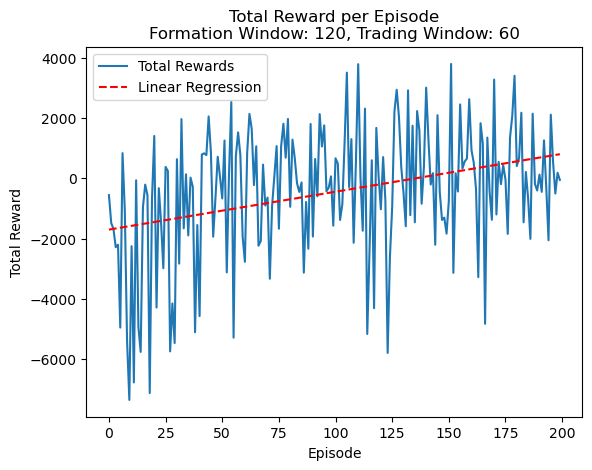

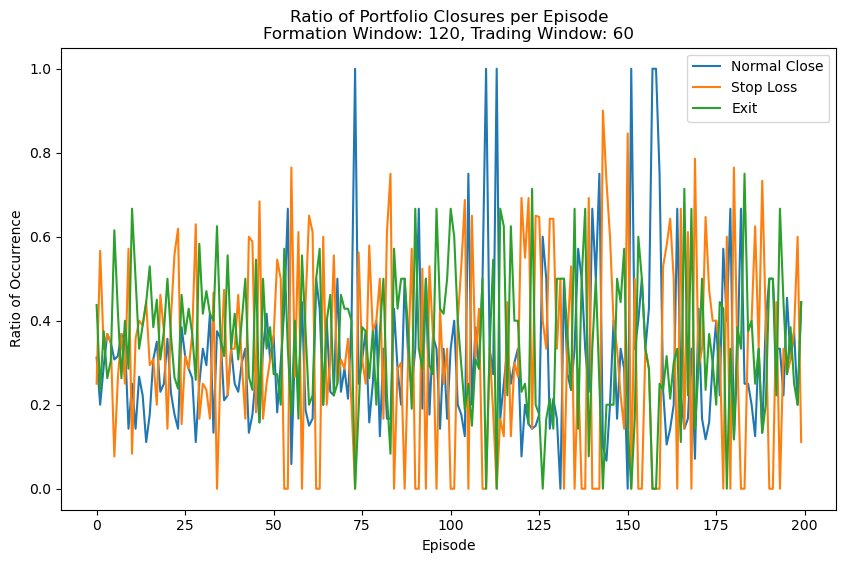

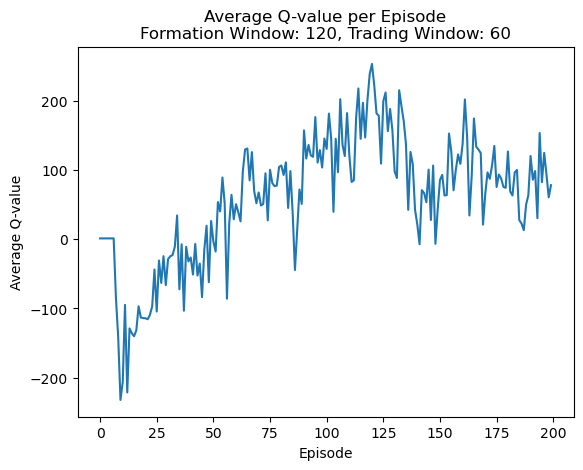

In [12]:
formation_window_sizes = [30, 60, 90, 120]
trading_window_sizes = [15, 20, 30, 60]

agents = []
total_rewards_list = []
avg_q_values_per_episode_list = []

for i, (formation_size, trading_size) in enumerate(zip(formation_window_sizes, trading_window_sizes)):
    agent, total_rewards, avg_q_values_per_episode = train_agent(
        training_prices=stock_Data(validated_pairs_data[1])[0],
        formation_window_size=formation_size,
        trading_window_size=trading_size
    )
    agents.append(agent)
    total_rewards_list.append(total_rewards)
    avg_q_values_per_episode_list.append(avg_q_values_per_episode)
    
    # Save the agent's state dict with a unique filename
    torch.save(agent.state_dict(), f'trained_agent_{i+1}.pth')


## 5.Evaluation

#### Implement the model on testing set. Using multiple evaluative metrics including total profits, maximum drawdown and sharpe ratio

In [13]:
def calculate_trade_profit(trade): # Define the function to calculate total profits
    position = trade['position']
    volume_A = trade['volume_A']
    volume_B = trade['volume_B']
    entry_price_A = trade['entry_price_A']
    entry_price_B = trade['entry_price_B']
    exit_price_A = trade['exit_price_A']
    exit_price_B = trade['exit_price_B']
    
    if position == 1:  # Long position
        profit = (
            volume_A * (exit_price_A - entry_price_A)/entry_price_A +
            volume_B * (entry_price_B - exit_price_B)/entry_price_B
        )
    elif position == -1:  # Short position
        profit = (
            volume_A * (entry_price_A - exit_price_A)/entry_price_A +
            volume_B * (exit_price_B - entry_price_B)/entry_price_B
        )
    else:
        profit = 0
    return profit

In [14]:
def calculate_max_drawdown(cumulative_returns): # Design a function to calculate maximum drawdown
    """Calculate the maximum drawdown according to MDD(T) formula.
    
    Args:
        cumulative_returns: numpy array of cumulative account balance/returns
    
    Returns:
        Maximum drawdown as a percentage of the peak balance
    """
    acc_balance = cumulative_returns  # This is our AccBalance(t)
    rolling_max = np.maximum.accumulate(acc_balance)  # Peak values up to time t
    
    # Calculate drawdown percentage at each time t
    # Note: using np.finfo(float).eps to avoid division by zero
    drawdown = (acc_balance-rolling_max) / rolling_max
    
    # Get the maximum drawdown
    max_drawdown = np.min(drawdown)
    
    return max_drawdown

In [15]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.01):
    """Calculate the Sharpe ratio for a series of returns.
    
    Args:
        returns: numpy array of daily returns
        risk_free_rate: annual risk-free rate (default 2%)
    
    Returns:
        Sharpe ratio of the returns
    """
    # Convert daily returns to excess returns
    excess_returns = returns - (risk_free_rate / 252)  # Assuming 252 trading days per year
    
    # Calculate annualized Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / np.std(excess_returns))
    
    return sharpe_ratio

In [55]:
def evaluate_agent(agent, test_prices, formation_window_size, trading_window_size):
    env = PairsTradingEnv(
        prices=test_prices,
        formation_window_size=formation_window_size,
        trading_window_size=trading_window_size
    )

    state = env.reset()
    done = False
    
    # Get full date range for testing period
    dates = test_prices['dates']
    
    while not done:
        state = np.array(state, dtype=np.float32)
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = agent(state_tensor)
            action = torch.argmax(q_values).item()
        
        next_state, _, done, _ = env.step(action)
        state = next_state if next_state is not None else state
    
    trades = env.trades
    
    # Create a DataFrame with all dates and their corresponding balances
    daily_balance = pd.DataFrame(index=dates)
    daily_balance['balance'] = 1  # Initialize all days with starting balance
    current_balance = 1
    
    # Update balance on trade dates
    for trade in trades:
        trade_date = trade['exit_date']
        profit = calculate_trade_profit(trade)
        current_balance += profit
        daily_balance.loc[trade_date:, 'balance'] = current_balance
    
    # Plot with actual dates
    plt.figure(figsize=(10, 6))
    plt.plot(daily_balance.index, daily_balance['balance'], 
            color='red', linewidth=1.5, label='PTDQN',
            alpha=0.8)
    
    # Add light shading around the line
    window = 20  # for rolling mean
    rolling_std = daily_balance['balance'].rolling(window=window).std()
    rolling_mean = daily_balance['balance'].rolling(window=window).mean()
    
    plt.fill_between(daily_balance.index, 
                    rolling_mean - rolling_std, 
                    rolling_mean + rolling_std,
                    color='red', alpha=0.2)
    
    # Customize the plot
    plt.title('Portfolio Value Over Time', fontsize=12)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Profit', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Format axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Format date axis
    plt.gcf().autofmt_xdate()
    years = mdates.YearLocator(1)
    years_fmt = mdates.DateFormatter('%Y')
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(years_fmt)
    
    plt.tight_layout()
    # Calculate final metrics
    final_balance = daily_balance['balance'].iloc[-1]
    max_drawdown = calculate_max_drawdown(daily_balance['balance'].values)

    daily_returns = daily_balance['balance'].pct_change().dropna()
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)  # Using daily returns series
    
    return final_balance, max_drawdown, sharpe_ratio, daily_balance

In [ ]:
def load_trained_agent(state_dim, action_dim, model_path):
    # Initialize the model architecture
    agent = DQN(state_dim, action_dim)
    
    # Load the saved state dictionary
    agent.load_state_dict(torch.load(model_path, weights_only=True))
    

    return agent

#### For the selected stock pair, examine portfolio values from different models.

Selected Pair: ('BIIB', 'BSX')
total profit: 11.52719165534771
max drawdown: -0.43075015564608926
sharpe ratio: 0.49023340061620135


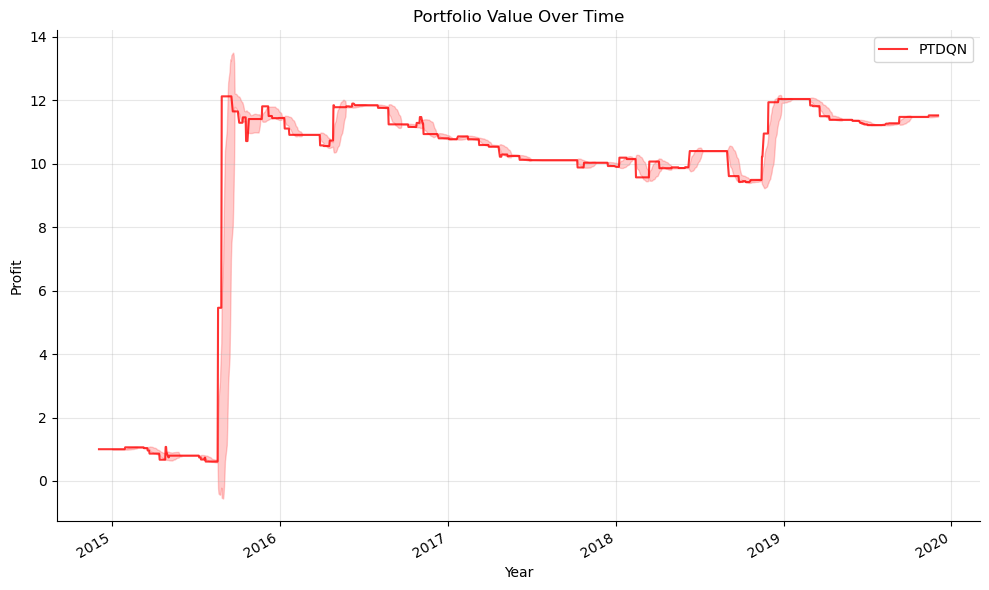

In [63]:
if __name__ == '__main__':
    # Parameters (ensure these match your model's parameters)
    formation_window_size = 30
    trading_window_size = 15
    
    # Load the trained agent
    agent1 = load_trained_agent(state_dim=3, action_dim=7, model_path='trained_agent_1.pth')
    # Set the model to evaluation mode
    agent1.eval()
    # Get test data
    # Get test data
    test_prices = stock_Data(validated_pairs_data[1])[0]
    # Evaluate the agent
    evaluation_results1 = evaluate_agent(
        agent1,
        test_prices,
        formation_window_size,
        trading_window_size
    )
    print('total profit:', evaluation_results1[0])
    print('max drawdown:', evaluation_results1[1])
    print('sharpe ratio:', evaluation_results1[2])

Selected Pair: ('BIIB', 'BSX')
total profit: 13.473054521764695
max drawdown: -0.2296964333632276
sharpe ratio: 0.8030624753926905


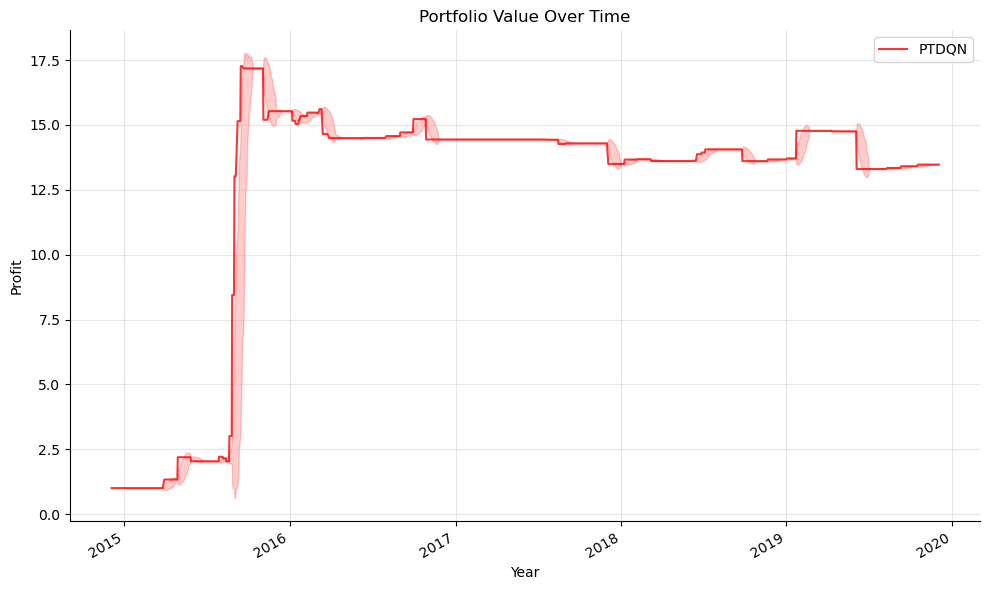

In [64]:
if __name__ == '__main__':
    # Parameters (ensure these match your model's parameters)
    formation_window_size = 60
    trading_window_size = 20
    
    # Load the trained agent
    agent2 = load_trained_agent(state_dim=3, action_dim=7, model_path='trained_agent_2.pth')
    # Set the model to evaluation mode
    agent2.eval()
    # Get test data
    # Get test data
    test_prices = stock_Data(validated_pairs_data[1])[0]
    # Evaluate the agent
    evaluation_results2 = evaluate_agent(
        agent2,
        test_prices,
        formation_window_size,
        trading_window_size
    )
    print('total profit:', evaluation_results2[0])
    print('max drawdown:', evaluation_results2[1])
    print('sharpe ratio:', evaluation_results2[2])

Selected Pair: ('BIIB', 'BSX')
total profit: 0.7179801914348083
max drawdown: -0.9286058678827472
sharpe ratio: 0.3520916728706749


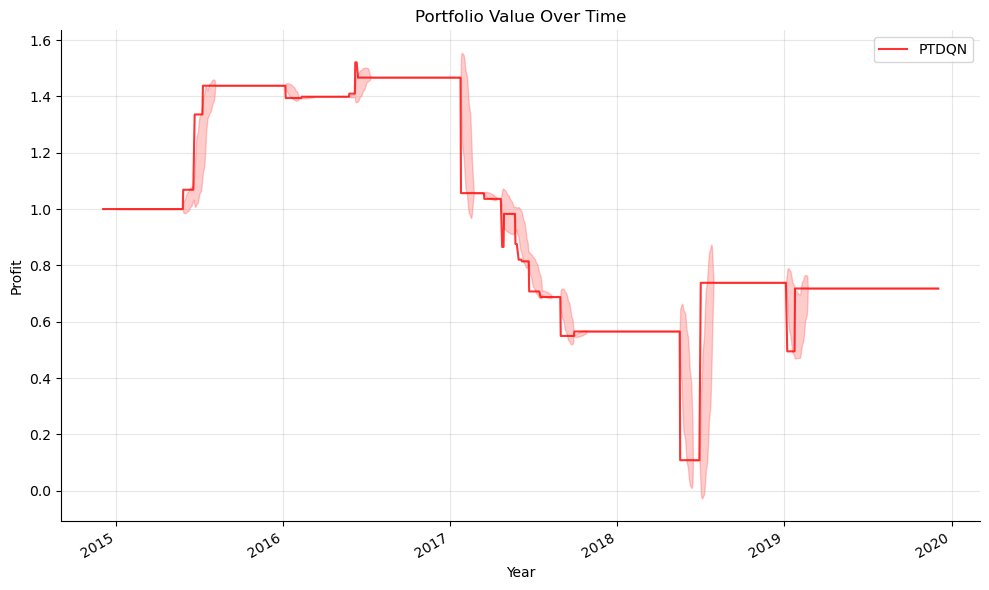

In [65]:
if __name__ == '__main__':
    # Parameters (ensure these match your model's parameters)
    formation_window_size = 90
    trading_window_size = 30
    
    # Load the trained agent
    agent3 = load_trained_agent(state_dim=3, action_dim=7, model_path='trained_agent_3.pth')
    # Set the model to evaluation mode
    agent3.eval()
    # Get test data
    # Get test data
    test_prices = stock_Data(validated_pairs_data[1])[0]
    # Evaluate the agent
    evaluation_results3 = evaluate_agent(
        agent3,
        test_prices,
        formation_window_size,
        trading_window_size
    )
    print('total profit:', evaluation_results3[0])
    print('max drawdown:', evaluation_results3[1])
    print('sharpe ratio:', evaluation_results3[2])

Selected Pair: ('BIIB', 'BSX')
total profit: 0.9345569801219749
max drawdown: -0.39921191298635
sharpe ratio: 0.0707257110877248


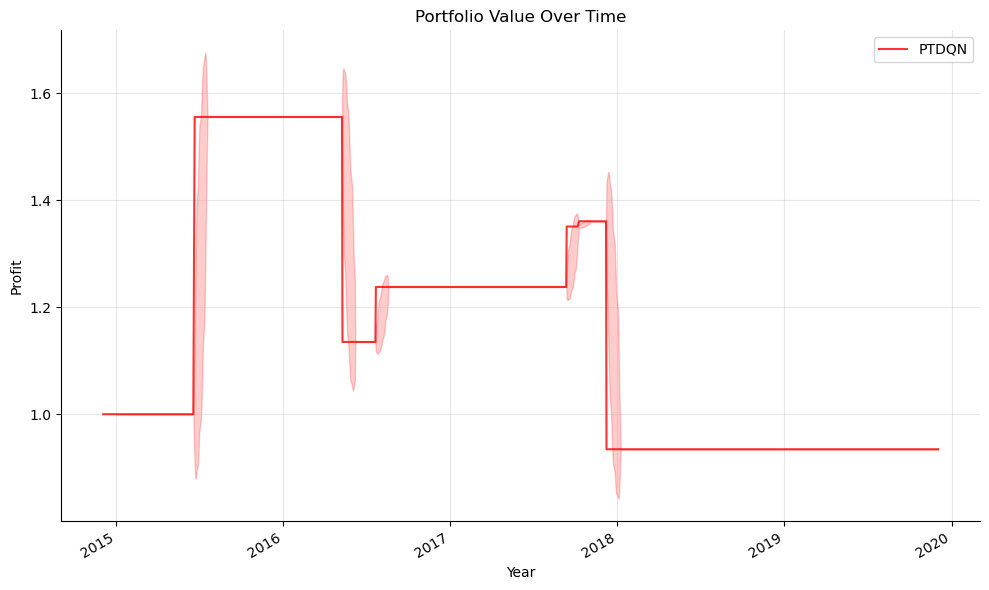

In [66]:
if __name__ == '__main__':
    # Parameters (ensure these match your model's parameters)
    formation_window_size = 120
    trading_window_size = 80
    
    # Load the trained agent
    agent4 = load_trained_agent(state_dim=3, action_dim=7, model_path='trained_agent_4.pth')


    # Set the model to evaluation mode
    agent4.eval()
    # Get test data
    test_prices = stock_Data(validated_pairs_data[1])[0]
    # Evaluate the agent
    evaluation_results4 = evaluate_agent(
        agent4,
        test_prices,
        formation_window_size,
        trading_window_size
    )
    print('total profit:', evaluation_results4[0])
    print('max drawdown:', evaluation_results4[1])
    print('sharpe ratio:', evaluation_results4[2])

#### Final PTDQN Model
#### Collect the two models with highest final profit out of the four models and use their average as our processed PTDQN

Average Total Profit: 12.5001
Average Max Drawdown: -0.3302
Average Sharpe Ratio: 0.6466


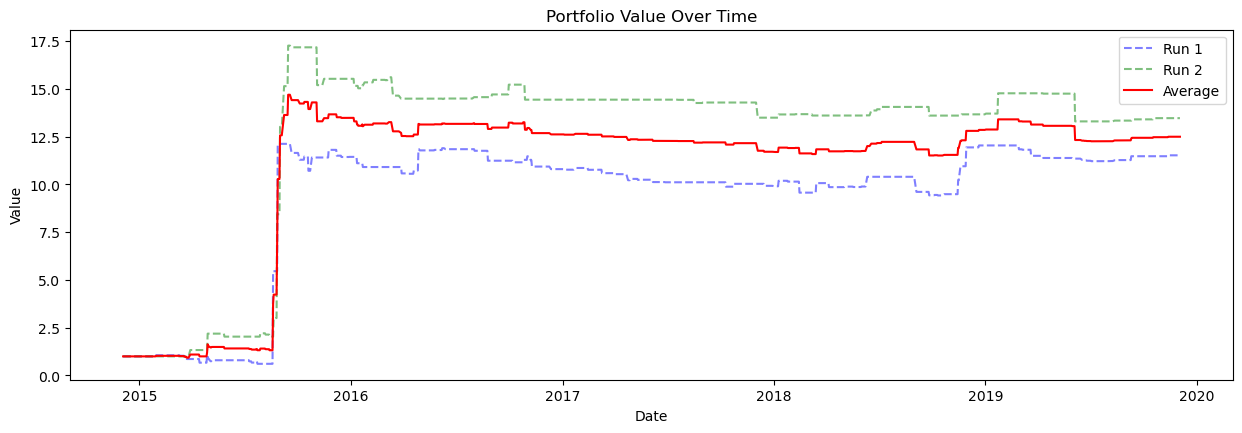

In [70]:
def plot_average_metrics(run1_results, run2_results):
    """
    Plot average metrics from two runs over time.
    
    Args:
        run1_results: Tuple of (final_balance, max_drawdown, sharpe_ratio, daily_balance) from first run
        run2_results: Tuple of (final_balance, max_drawdown, sharpe_ratio, daily_balance) from second run
    """
    # Calculate averages of scalar metrics
    avg_profit = (run1_results[0] + run2_results[0]) / 2
    avg_drawdown = (run1_results[1] + run2_results[1]) / 2
    avg_sharpe = (run1_results[2] + run2_results[2]) / 2
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # Plot Daily Balance (larger subplot)
    ax_balance = fig.add_subplot(gs[0, :])
    
    # Align the daily balance DataFrames
    common_dates = run1_results[3].index.intersection(run2_results[3].index)
    balance1 = run1_results[3].loc[common_dates]['balance']
    balance2 = run2_results[3].loc[common_dates]['balance']
    
    # Calculate average daily balance
    avg_balance = (balance1 + balance2) / 2
    
    # Plot individual runs and average
    ax_balance.plot(common_dates, balance1, 'b--', alpha=0.5, label='Run 1')
    ax_balance.plot(common_dates, balance2, 'g--', alpha=0.5, label='Run 2')
    ax_balance.plot(common_dates, avg_balance, 'r-', label='Average')
    ax_balance.set_title('Portfolio Value Over Time')
    ax_balance.set_xlabel('Date')
    ax_balance.set_ylabel('Value')
    ax_balance.legend()
    
    

    
    return avg_profit,avg_drawdown,avg_sharpe,avg_balance
PTDQN=plot_average_metrics(evaluation_results1, evaluation_results2)
# Print numerical results
print(f"Average Total Profit: {PTDQN[0]:.4f}")
print(f"Average Max Drawdown: {PTDQN[1]:.4f}")
print(f"Average Sharpe Ratio: {PTDQN[2]:.4f}")

In [54]:
def traditional_pairs_trading(prices, trading_boundaries=2, stop_loss=4):
    """
    Basic pairs trading strategy with fixed boundaries for comparison
    
    Args:
        prices: DataFrame containing price data for both stocks
        trading_boundaries: Number of std deviations for entry (default 2)
        stop_loss: Number of std deviations for stop loss (default 5)
    
    Returns:
        final_balance, max_drawdown, sharpe_ratio, daily_balance
    """
    # Extract prices for both stocks
    stock_A = prices['stock_A']
    stock_B = prices['stock_B']
    dates = prices['dates']
    
    # Calculate spread and hedge ratio
    hedge_ratio = np.polyfit(stock_B, stock_A, 1)[0]
    spread = stock_A - hedge_ratio * stock_B
    
    # Calculate rolling statistics
    lookback = 75
    spread_mean = spread.rolling(window=lookback).mean()
    spread_std = spread.rolling(window=lookback).std()
    z_score = (spread - spread_mean) / spread_std
    
    # Initialize tracking variables
    position = 0  # 0: no position, 1: long spread, -1: short spread
    daily_balance = pd.DataFrame(index=dates)
    daily_balance['balance'] = 1.0
    current_balance = 1.0
    volume_A = 1.0  # Fixed volume for stock A
    volume_B = hedge_ratio  # Volume for stock B based on hedge ratio
    
    # Trading loop
    for i in range(lookback, len(dates)):
        current_zscore = z_score.iloc[i]
        
        # Skip if z-score is NaN
        if np.isnan(current_zscore):
            daily_balance['balance'].iloc[i] = current_balance
            continue
        
        # Trading logic similar to DQN but with fixed boundaries
        if position == 0:  # No position
            if current_zscore > trading_boundaries and current_zscore < stop_loss:
                # Short spread: Short A, Long B
                position = -1
                entry_price_A = stock_A.iloc[i]
                entry_price_B = stock_B.iloc[i]
            elif current_zscore < -trading_boundaries and current_zscore > -stop_loss:
                # Long spread: Long A, Short B
                position = 1
                entry_price_A = stock_A.iloc[i]
                entry_price_B = stock_B.iloc[i]
                
        elif position == 1:  # Long spread position
            if current_zscore > 0 or current_zscore < -stop_loss:
                # Close position
                exit_price_A = stock_A.iloc[i]
                exit_price_B = stock_B.iloc[i]
                # Calculate profit using volumes and actual prices
                profit = volume_A * (exit_price_A - entry_price_A) / entry_price_A \
                       + volume_B * (entry_price_B - exit_price_B) / entry_price_B
                current_balance += profit
                position = 0
                
        elif position == -1:  # Short spread position
            if current_zscore < 0 or current_zscore > stop_loss:
                # Close position
                exit_price_A = stock_A.iloc[i]
                exit_price_B = stock_B.iloc[i]
                # Calculate profit using volumes and actual prices
                profit = volume_A * (entry_price_A - exit_price_A) / entry_price_A \
                       + volume_B * (exit_price_B - entry_price_B) / entry_price_B
                current_balance += profit
                position = 0
        
        daily_balance['balance'].iloc[i] = current_balance
    
    # Fill forward any missing values
    daily_balance['balance'] = daily_balance['balance'].fillna(method='ffill')
    
    # Calculate daily returns
    daily_returns = daily_balance['balance'].pct_change().dropna()
    
    # Calculate metrics
    final_balance = daily_balance['balance'].iloc[-1]
    max_drawdown = calculate_max_drawdown(daily_balance['balance'].values)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns.values)
    
    return final_balance, max_drawdown, sharpe_ratio, daily_balance

test_prices = stock_Data(validated_pairs_data[1])[0]
results = traditional_pairs_trading(test_prices)
print('Simple Strategy Results:')
print('Total profit:', results[0])
print('Max drawdown:', results[1])
print('Sharpe ratio:', results[2])


Selected Pair: ('BIIB', 'BSX')
Simple Strategy Results:
Total profit: 3.0464920312691026
Max drawdown: -0.19756936254577975
Sharpe ratio: 0.8430006415751259



#### Generate pairs trading strategies with traditional fixed-boundary settings


Selected Pair: ('BIIB', 'BSX')


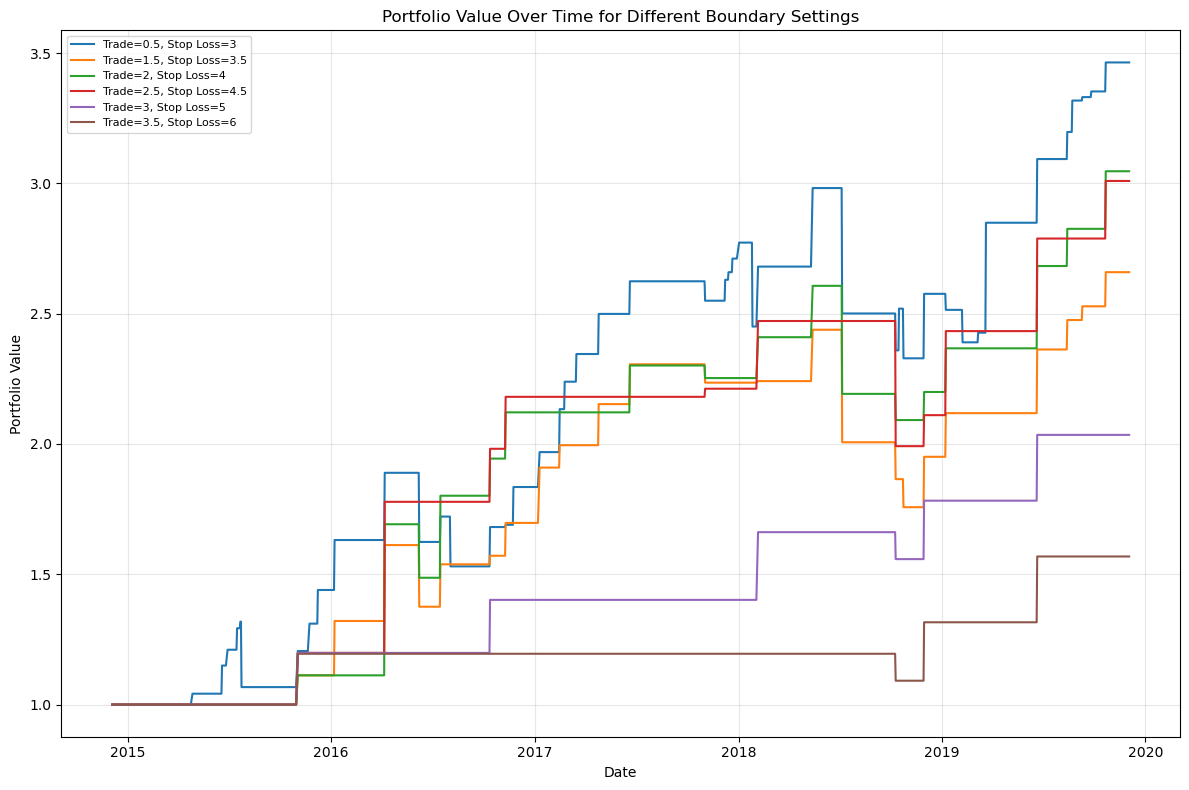

Settings: Trade=0.5, Stop Loss=3
Total profit: 3.4640019426255
Max drawdown: -0.21905528523529127
Sharpe ratio: 1.044308004781059
----------------------------------------
Settings: Trade=1.5, Stop Loss=3.5
Total profit: 2.659295809050181
Max drawdown: -0.27925755626251997
Sharpe ratio: 0.9345130605891533
----------------------------------------
Settings: Trade=2, Stop Loss=4
Total profit: 3.0464920312691026
Max drawdown: -0.19756936254577975
Sharpe ratio: 0.8430006415751259
----------------------------------------
Settings: Trade=2.5, Stop Loss=4.5
Total profit: 3.0092503179857943
Max drawdown: -0.19427931804510926
Sharpe ratio: 0.8638052238104086
----------------------------------------
Settings: Trade=3, Stop Loss=5
Total profit: 2.0349336635280846
Max drawdown: -0.06223255417652563
Sharpe ratio: 0.8497977533160942
----------------------------------------
Settings: Trade=3.5, Stop Loss=6
Total profit: 1.568381483524522
Max drawdown: -0.08652699967351409
Sharpe ratio: 0.57893626582469

In [ ]:
# Neglect inf boundary pairs since there would be no trading throughout
boundary_settings = [
    {'trade': 0.5, 'stop_loss': 3},
    {'trade': 1.5, 'stop_loss': 3.5},
    {'trade': 2, 'stop_loss': 4},
    {'trade': 2.5, 'stop_loss': 4.5},
    {'trade': 3, 'stop_loss': 5},
    {'trade': 3.5, 'stop_loss': 6},
]

# Get the test prices
test_prices = stock_Data(validated_pairs_data[1])[0]

# Initialize lists to store results
all_daily_balances = []
results = []

# Run the traditional_pairs_trading function for each boundary setting
for settings in boundary_settings:
    final_balance, max_drawdown, sharpe_ratio, daily_balance = traditional_pairs_trading(
        test_prices,
        trading_boundaries=settings['trade'],
        stop_loss=settings['stop_loss']
    )
    
    # Store the results
    all_daily_balances.append({'settings': settings, 'daily_balance': daily_balance})
    results.append({
        'settings': settings,
        'final_balance': final_balance,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    })

# Plot the daily balances for each boundary setting
plt.figure(figsize=(12, 8))

for item in all_daily_balances:
    settings = item['settings']
    daily_balance = item['daily_balance']
    label = f"Trade={settings['trade']}, Stop Loss={settings['stop_loss']}"
    plt.plot(daily_balance.index, daily_balance['balance'].values, label=label)

plt.title('Portfolio Value Over Time for Different Fixed Boundary Settings', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Portfolio Value', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the performance metrics for each boundary setting
for res in results:
    settings = res['settings']
    print(f"Settings: Trade={settings['trade']}, Stop Loss={settings['stop_loss']}")
    print(f"Total profit: {res['final_balance']}")
    print(f"Max drawdown: {res['max_drawdown']}")
    print(f"Sharpe ratio: {res['sharpe_ratio']}")
    print('----------------------------------------')

## 6. Results
#### Compare of Portfolio Value over 5 years of time between trational fixed boundary pair trading startegies and DQN selected non-explicitly defined boundary pair trading startegies

Selected Pair: ('BIIB', 'BSX')


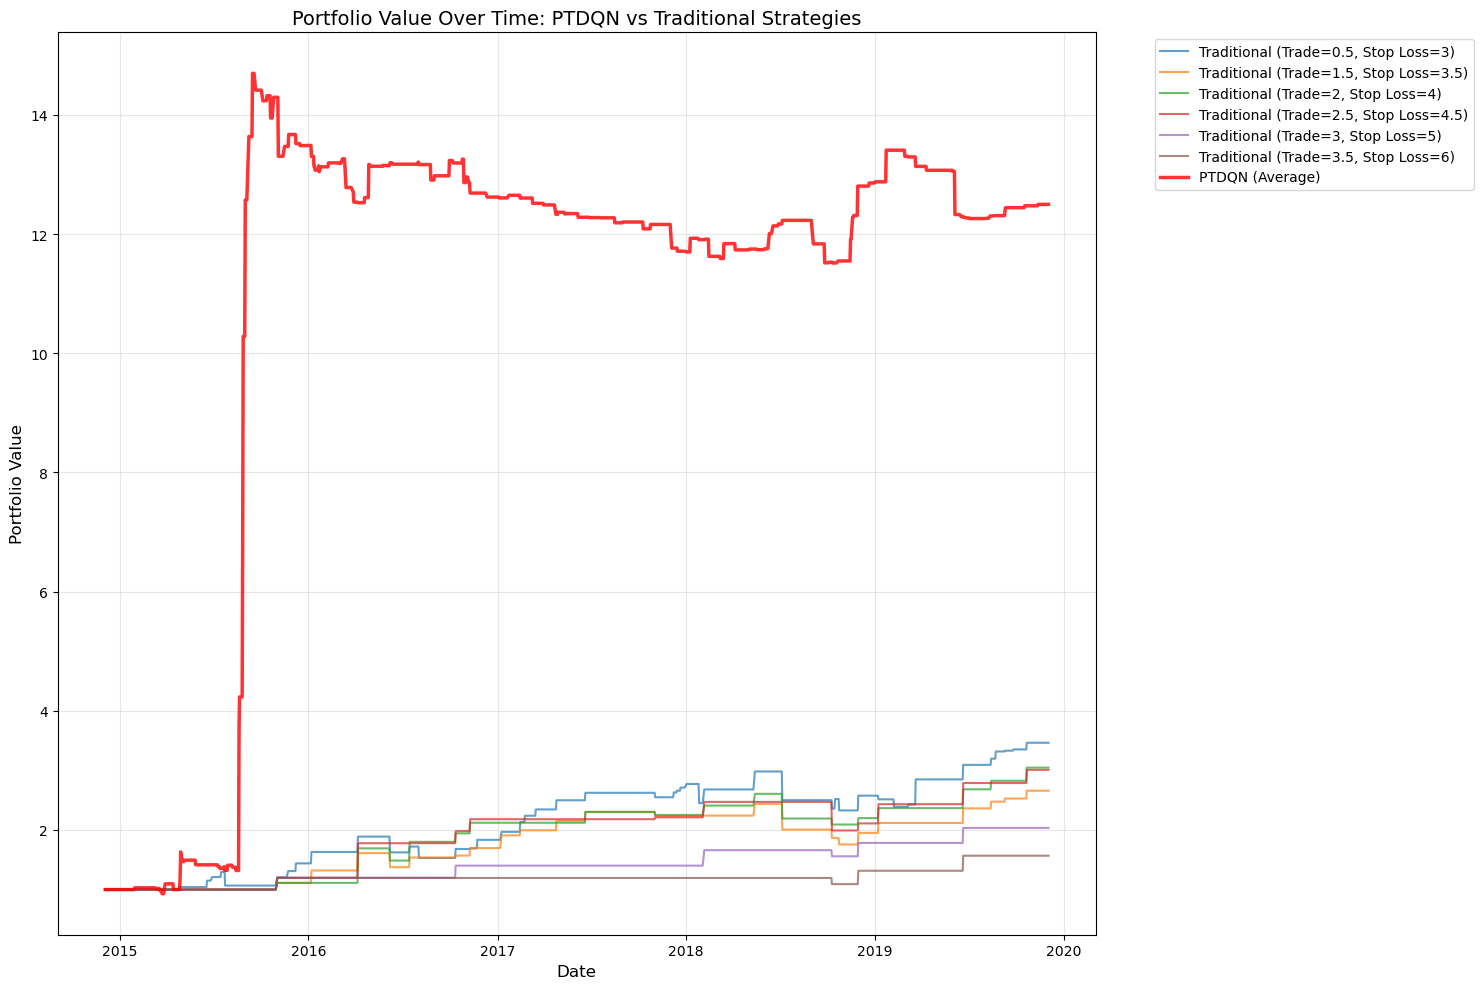


Performance Comparison:
--------------------------------------------------
PTDQN Results:
Total profit: 12.5001
Max drawdown: -0.3302
Sharpe ratio: 0.6466

Traditional Strategy Results:

Settings: Trade=0.5, Stop Loss=3
Total profit: 3.4640
Max drawdown: -0.2191
Sharpe ratio: 1.0443

Settings: Trade=1.5, Stop Loss=3.5
Total profit: 2.6593
Max drawdown: -0.2793
Sharpe ratio: 0.9345

Settings: Trade=2, Stop Loss=4
Total profit: 3.0465
Max drawdown: -0.1976
Sharpe ratio: 0.8430

Settings: Trade=2.5, Stop Loss=4.5
Total profit: 3.0093
Max drawdown: -0.1943
Sharpe ratio: 0.8638

Settings: Trade=3, Stop Loss=5
Total profit: 2.0349
Max drawdown: -0.0622
Sharpe ratio: 0.8498

Settings: Trade=3.5, Stop Loss=6
Total profit: 1.5684
Max drawdown: -0.0865
Sharpe ratio: 0.5789


In [78]:
# Neglect inf boundary pairs since there would be no trading throughout
boundary_settings = [
    {'trade': 0.5, 'stop_loss': 3},
    {'trade': 1.5, 'stop_loss': 3.5},
    {'trade': 2, 'stop_loss': 4},
    {'trade': 2.5, 'stop_loss': 4.5},
    {'trade': 3, 'stop_loss': 5},
    {'trade': 3.5, 'stop_loss': 6},
]

# Get the test prices
test_prices = stock_Data(validated_pairs_data[1])[0]

# Initialize lists to store results
all_daily_balances = []
results = []

# Run the traditional_pairs_trading function for each boundary setting
for settings in boundary_settings:
    final_balance, max_drawdown, sharpe_ratio, daily_balance = traditional_pairs_trading(
        test_prices,
        trading_boundaries=settings['trade'],
        stop_loss=settings['stop_loss']
    )
    
    # Store the results
    all_daily_balances.append({'settings': settings, 'daily_balance': daily_balance})
    results.append({
        'settings': settings,
        'final_balance': final_balance,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    })

# Create the plot with a larger figure size
plt.figure(figsize=(15, 10))

# Plot traditional strategies
for item in all_daily_balances:
    settings = item['settings']
    daily_balance = item['daily_balance']
    label = f"Traditional (Trade={settings['trade']}, Stop Loss={settings['stop_loss']})"
    plt.plot(daily_balance.index, daily_balance['balance'].values, '-', alpha=0.7, label=label)

# Add PTDQN results
plt.plot(PTDQN[3].index, PTDQN[3].values, 'r-', linewidth=2.5, label='PTDQN (Average)', alpha=0.8)

plt.title('Portfolio Value Over Time: PTDQN vs Traditional Strategies', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print performance comparison
print("\nPerformance Comparison:")
print("-" * 50)
print("PTDQN Results:")
print(f"Total profit: {PTDQN[0]:.4f}")
print(f"Max drawdown: {PTDQN[1]:.4f}")
print(f"Sharpe ratio: {PTDQN[2]:.4f}")
print("\nTraditional Strategy Results:")
for res in results:
    settings = res['settings']
    print(f"\nSettings: Trade={settings['trade']}, Stop Loss={settings['stop_loss']}")
    print(f"Total profit: {res['final_balance']:.4f}")
    print(f"Max drawdown: {res['max_drawdown']:.4f}")
    print(f"Sharpe ratio: {res['sharpe_ratio']:.4f}")

In [80]:
# Create a list to store all results
table_data = []

# Add PTDQN results first
table_data.append({
    'Model': 'PTDQN',
    'Trading Boundary': 'Dynamic',
    'Stop Loss': 'Dynamic',
    'Total Profit': PTDQN[0],
    'Max Drawdown': PTDQN[1],
    'Sharpe Ratio': PTDQN[2]
})

# Add traditional models in predefined order with numbered labels
for i, res in enumerate(results, 1):
    settings = res['settings']
    table_data.append({
        'Model': f'PTT{i}',  # Changed from 'Traditional' to 'PTTn'
        'Trading Boundary': settings['trade'],
        'Stop Loss': settings['stop_loss'],
        'Total Profit': res['final_balance'],
        'Max Drawdown': res['max_drawdown'],
        'Sharpe Ratio': res['sharpe_ratio']
    })

# Create DataFrame
df = pd.DataFrame(table_data)

# Format numeric columns
df['Total Profit'] = df['Total Profit'].round(4)
df['Max Drawdown'] = df['Max Drawdown'].round(4)
df['Sharpe Ratio'] = df['Sharpe Ratio'].round(4)

# Display the table
print("\nPerformance Comparison Table:")
print("-" * 100)
print(df.to_string(index=False))

# Optionally, save to CSV
# df.to_csv('performance_comparison.csv', index=False)


Performance Comparison Table:
----------------------------------------------------------------------------------------------------
Model Trading Boundary Stop Loss  Total Profit  Max Drawdown  Sharpe Ratio
PTDQN          Dynamic   Dynamic       12.5001       -0.3302        0.6466
 PTT1              0.5         3        3.4640       -0.2191        1.0443
 PTT2              1.5       3.5        2.6593       -0.2793        0.9345
 PTT3                2         4        3.0465       -0.1976        0.8430
 PTT4              2.5       4.5        3.0093       -0.1943        0.8638
 PTT5                3         5        2.0349       -0.0622        0.8498
 PTT6              3.5         6        1.5684       -0.0865        0.5789
